# Statistical Methods in Astrophysics Exercises

## Week 07: Regression & Samplers

### Personal Information

**Name:** physnya

### Exercise 1: Light curve fitting

The brightness of a variable star varies with time following the following sinusoidal model:

$m(t) = A \sin \left( \dfrac{2 \pi t}{T} + \phi \right) + m_0$

where $A$ is the amplitude, $T$ is the period, $\phi$ is the phase, and $m_0$ is the mean magnitude.

The star is observed at $N=32$ different random times $t_i$ (in days) over a year. Due to the variability of observing conditions, the measurement uncertainties of the observed magnitudes follow a heteroscedastic distribution, i.e., different data points have different uncertainties.

The expected uncertainties $\{\sigma_i\}$ are uniformly distributed between 0.2 mag and 0.4 mag. The observed magnitudes $m_i$ are generated by adding Gaussian noise to the true magnitudes at the observation times:

$m_i = m(t_i) + \epsilon_i$,

where $\epsilon_i \sim \mathcal{N}(0, \sigma_i^2)$, i.e., Gaussian noise with zero mean and standard deviation $\sigma_i$.

#### Question 1.1: Gaussian process regression

For Gaussian process regression, the kernel function describes the covariance between different data points. We consider the Radial Basis Function (RBF) kernel and the periodic kernel for this exercise.

1. The Radial Basis Function (RBF) kernel is defined as:

   $k(x_i, x_j) = \sigma^2 \exp \left( -\dfrac{(x_i - x_j)^2}{2 l^2} \right)$

   where $\sigma^2$ is the signal variance and $l$ is the length scale.

2. The periodic kernel is defined as:

   $k(x_i, x_j) = \sigma^2 \exp \left( -\dfrac{2 \sin^2 \left( \pi |x_i - x_j| / p \right)}{l^2} \right)$

   where $\sigma^2$ is the signal variance, $l$ is the length scale, and $p$ is the period. For simplicity, we fix $\sigma^2 = 1$ for the periodic kernel.


**Tasks:**
1. Simulate the light curve data $\{t_i, m_i, \sigma_i\}$ using the following true parameters: $A=1.5$ mag, $T=100$ days, $\phi=1$ rad, and $m_0=15$ mag. Plot the simulated light curve data with error bars, and overlay the true light curve model.
2. Predict the brightness of the star at $t=[100,200,300,400]$ days along with the associated uncertainties using Gaussian process regression with both the RBF and periodic kernels, and compare the results with those from the true model.
3. Plot the predictive bands (mean ± 1σ) from both the RBF and periodic kernels over the time range of 0 to 400 days.

**Hints:**
1. You can use the `GaussianProcessRegressor` class from the `sklearn.gaussian_process` module to perform Gaussian process regression. Make sure to incorporate the measurement uncertainties $\sigma_i$ into the regression model.
2. The RBF kernel can be implemented using the `RBF` class from the `sklearn.gaussian_process.kernels` module.
3. The periodic kernel with $\sigma^2 = 1$ can be implemented using the `ExpSineSquared` class from the `sklearn.gaussian_process.kernels` module.

In [98]:
# NOTE: Run this cell in the first place
# Load packages for numerical calculations and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Enable inline plotting in Jupyter notebooks
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300
%matplotlib inline
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [99]:
# Uncomment to suppress UltraNest debugging info (only run this if you finish all exercises and would like concise outputs)
import logging, sys
logger = logging.getLogger("ultranest")
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.ERROR)
logger.addHandler(handler)
logger.setLevel(logging.ERROR)

In [100]:
def lightcurve_model(t, A, T, phi, m0):
    """Light curve model: sinusoidal variability.
    Args:
        t: array, time array in days
        A: float, amplitude of variability
        T: float, period of variability in days
        phi: float, phase of variability
        m0: float, mean magnitude
    Returns:
        m: array, model magnitudes at times t
    """
    m = A * np.sin(2 * np.pi * t / T + phi) + m0
    return m

def sim_lightcurve(ndays, A=1.5, T=100, phi=1.0, m0=15, seed=42):
    """Simulate a light curve with Gaussian noise.
    Args:
        ndays: int, number of days to simulate
        A: float, amplitude of variability
        T: float, period of variability in days
        phi: float, phase of variability
        m0: float, mean magnitude
        seed: int, random seed for reproducibility
    Returns:
        t: array, time array in days
        m_obs: array, observed magnitudes with noise
        sigma: array, measurement uncertainties
    """
    # NOTE: EDIT below to complete this function
    rng = np.random.default_rng(seed)
    # observation times (days) drawn randomly over one year
    t = rng.uniform(0, 365, size=ndays)
    # heteroscedastic uncertainties between 0.2 and 0.4 mag
    sigma = rng.uniform(0.2, 0.4, size=ndays)
    # true magnitudes and noisy observations
    m_true = lightcurve_model(t, A, T, phi, m0)
    m_obs = m_true + rng.normal(0.0, sigma)
    # sort by time for nicer plotting
    idx = np.argsort(t)
    t = t[idx]
    m_obs = m_obs[idx]
    sigma = sigma[idx]
    return t, m_obs, sigma

In [ ]:
# Set the random seed
seed = 2024011182  # NOTE: EDIT HERE to insert your seed

# Setup parameters
ndays = 32
param_names = ['A', 'T', 'phi', 'm0']
param_true = [1.5, 100, 1.0, 15.0]
param_ranges = np.array([(0, 3), (10, 300), (0, 2*np.pi), (10, 20)])

# Simulate the light curve
t, m_obs, sigma = sim_lightcurve(ndays, *param_true, seed=seed)

x_model = np.linspace(0, 400, 1000)
y_model = lightcurve_model(x_model, *param_true)

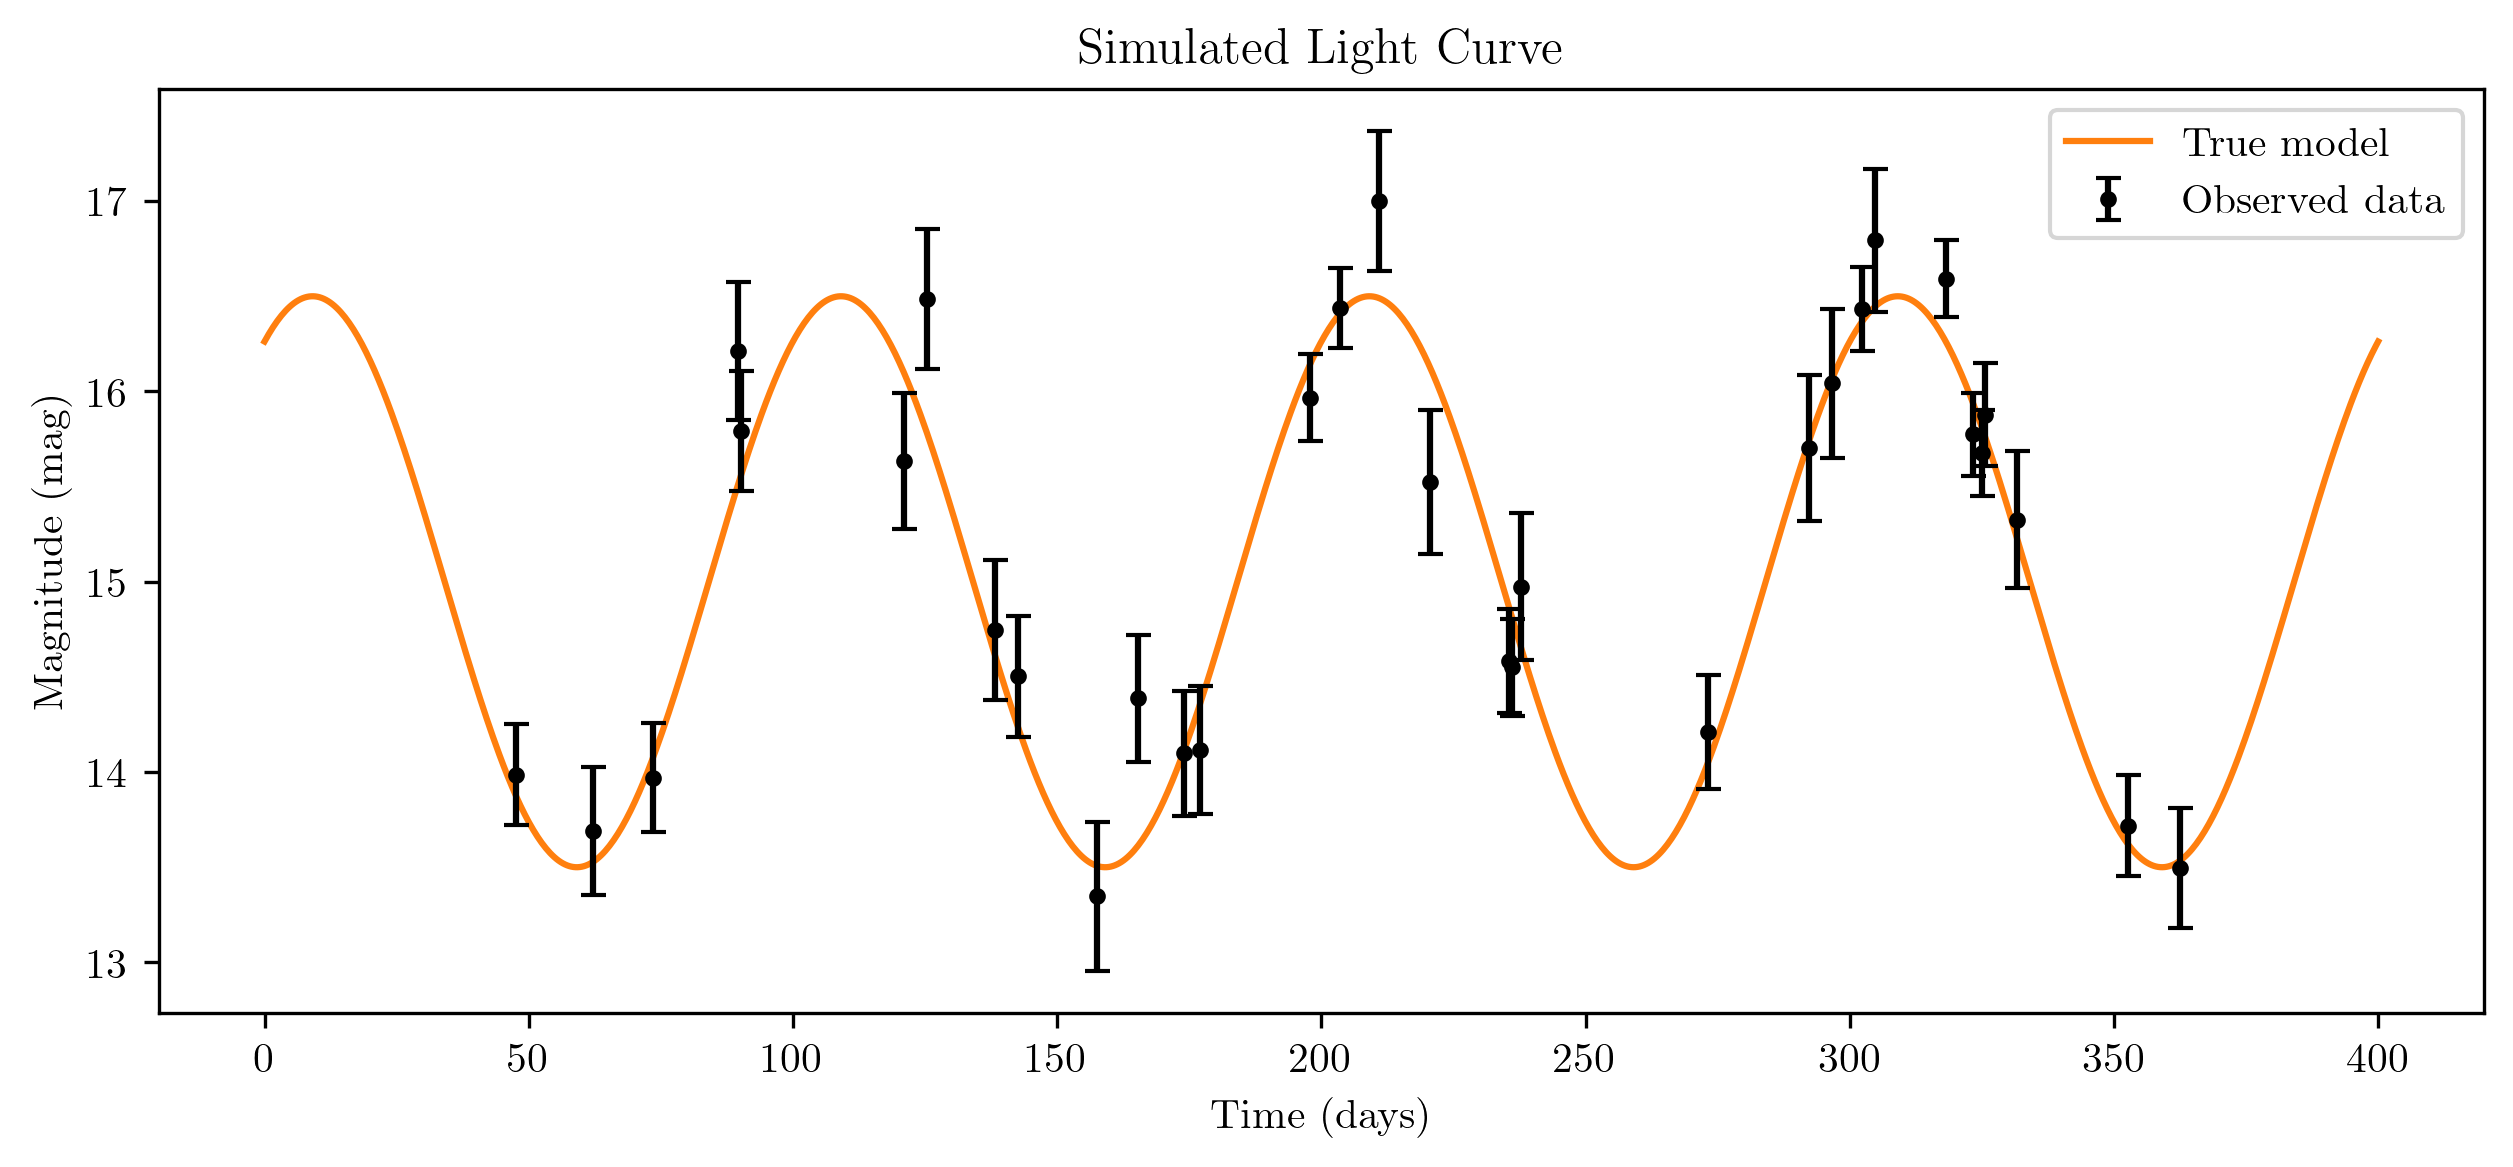

In [102]:
plt.figure(figsize=(10, 4))

plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)

plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.title('Simulated Light Curve')
plt.legend()
plt.show()

In [103]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared

# Define the RBF kernel with length scale bounds
kernel_rbf = 1.0 * RBF(length_scale_bounds=(0.01, 400))

# Create the Gaussian Process model with RBF kernel
gp_rbf = GaussianProcessRegressor(kernel=kernel_rbf,
        alpha=sigma**2 + 1e-8,    # NOTE: EDIT here to set the variance of the measurement noise
        normalize_y=True,         # normalize the target values for zero mean and unit variance
        n_restarts_optimizer=10,  # steps to perform during hyperparameter optimization
        random_state=seed+1
)

# Fit to the observed data
gp_rbf.fit(t.reshape(-1, 1), m_obs)

GaussianProcessRegressor(alpha=array([0.07115986, 0.11369829, 0.08167243, 0.13187349, 0.10001009,
       0.12760449, 0.13564863, 0.13517209, 0.10022079, 0.15317858,
       0.11068163, 0.10852515, 0.11290723, 0.05213118, 0.04416804,
       0.13512367, 0.14350412, 0.07509209, 0.06545762, 0.15027231,
       0.08981334, 0.14751943, 0.15437905, 0.04889111, 0.14035868,
       0.04137009, 0.04736292, 0.05196575, 0.07326026, 0.13052776,
       0.070403  , 0.09973682]),
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=2024011183)

In [104]:
t_test = np.array([100, 200, 300, 400])
m_test_true = lightcurve_model(t_test, *param_true)

# NOTE: EDIT below to make predictions with the trained GP model
m_pred_rbf, sigma_pred_rbf = gp_rbf.predict(t_test.reshape(-1, 1), return_std=True)

# Relative errors
rel_error_rbf = np.abs(m_pred_rbf - m_test_true) / np.abs(m_test_true)
# Relative errors normalized by predicted uncertainties
rel_error_norm_rbf = np.abs(m_pred_rbf - m_test_true) / sigma_pred_rbf

print("Predictions with RBF kernel:")
for ti, mi, si, re, re_norm in zip(t_test.flatten(), m_pred_rbf, sigma_pred_rbf, rel_error_rbf, rel_error_norm_rbf):
    print(f"t = {ti:.1f} days:\n\tm = {mi:.3f} ± {si:.3f} mag (relative error = {re:.2%}, normalized = {re_norm:.2f} sigma)")

Predictions with RBF kernel:
t = 100.0 days:
	m = 16.430 ± 0.363 mag (relative error = 1.03%, normalized = 0.46 sigma)
t = 200.0 days:
	m = 16.206 ± 0.162 mag (relative error = 0.34%, normalized = 0.35 sigma)
t = 300.0 days:
	m = 16.337 ± 0.169 mag (relative error = 0.46%, normalized = 0.44 sigma)
t = 400.0 days:
	m = 14.913 ± 1.095 mag (relative error = 8.30%, normalized = 1.23 sigma)


/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


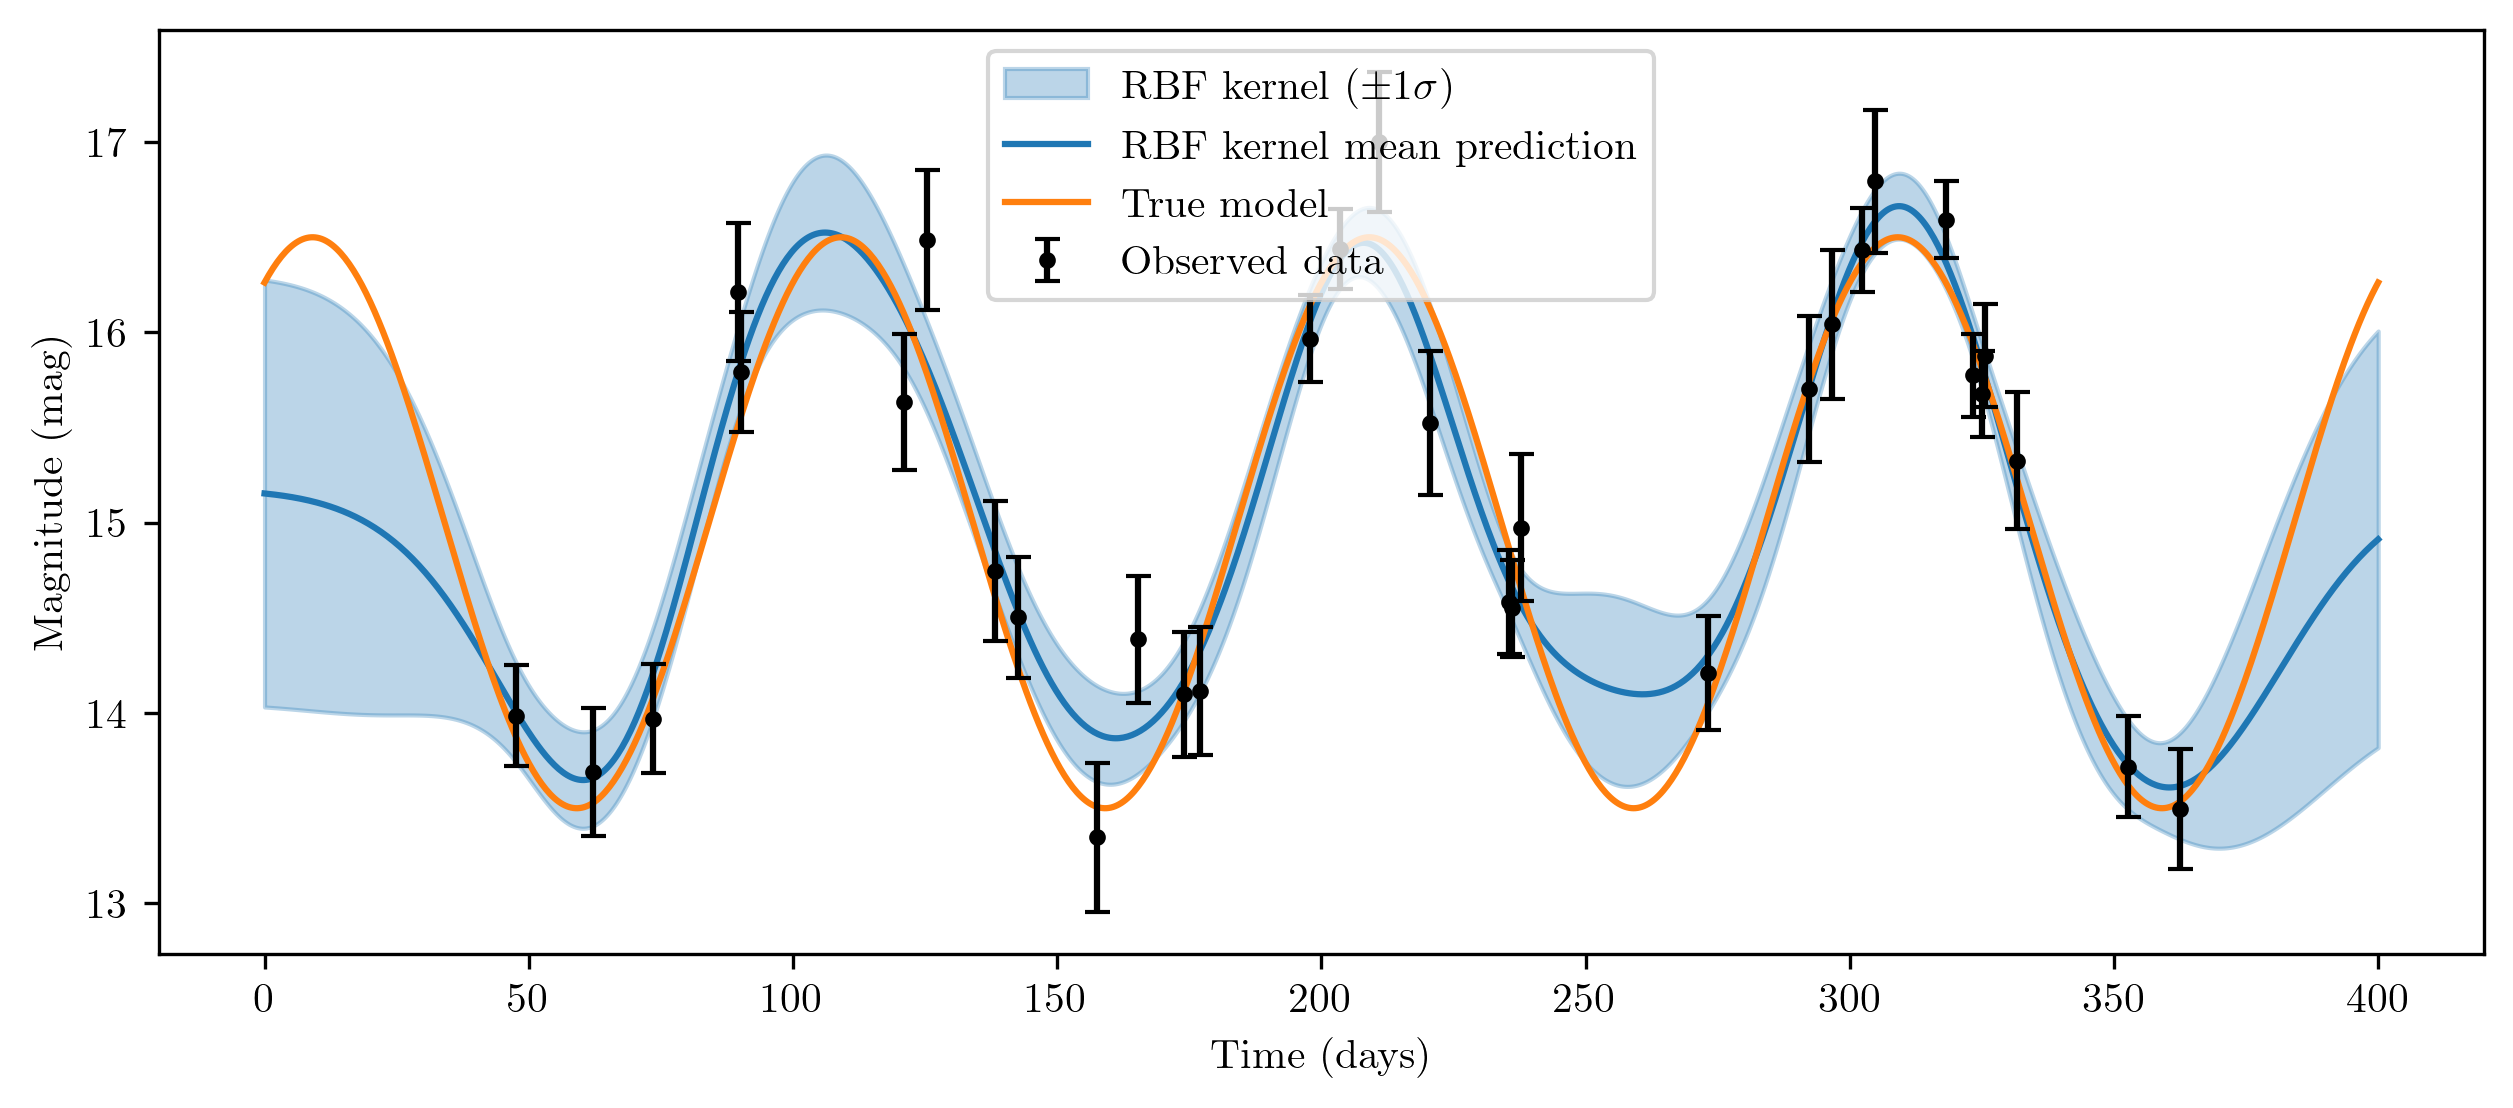

In [105]:
t_full = np.linspace(0, 400, 1000)
m_pred_full_rbf, sigma_pred_full_rbf = gp_rbf.predict(t_full.reshape(-1, 1), return_std=True)

# Plot the predictive bands from RBF kernel
plt.figure(figsize=(10, 4))
plt.fill_between(t_full, m_pred_full_rbf - sigma_pred_full_rbf,
                 m_pred_full_rbf + sigma_pred_full_rbf,
                 color='tab:blue', alpha=0.3, label=r'RBF kernel ($\pm1\sigma$)')
plt.plot(t_full, m_pred_full_rbf, color='tab:blue', label='RBF kernel mean prediction')

# Overlay the true model and simulated data
plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)

plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.legend()
plt.show()

In [106]:
# Define the periodic kernel with length scale and periodicity bounds
kernel_pd = 1.0 * ExpSineSquared(length_scale_bounds=(0.01, 400),
                                 periodicity_bounds=(10, 300))

# Create the Gaussian Process model with periodic kernel
gp_pd = GaussianProcessRegressor(kernel=kernel_pd,
        alpha=sigma**2 + 1e-8,    # NOTE: EDIT here to set the variance of the measurement noise
        normalize_y=True,         # normalize the target values for zero mean and unit variance
        n_restarts_optimizer=10,  # steps to perform during hyperparameter optimization
        random_state=seed+2)

# NOTE: EDIT below to fit the observed data
gp_pd.fit(t.reshape(-1, 1), m_obs)

GaussianProcessRegressor(alpha=array([0.07115986, 0.11369829, 0.08167243, 0.13187349, 0.10001009,
       0.12760449, 0.13564863, 0.13517209, 0.10022079, 0.15317858,
       0.11068163, 0.10852515, 0.11290723, 0.05213118, 0.04416804,
       0.13512367, 0.14350412, 0.07509209, 0.06545762, 0.15027231,
       0.08981334, 0.14751943, 0.15437905, 0.04889111, 0.14035868,
       0.04137009, 0.04736292, 0.05196575, 0.07326026, 0.13052776,
       0.070403  , 0.09973682]),
                         kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=2024011184)

In [107]:
# NOTE: EDIT below to make predictions with the trained GP model
m_pred_pd, sigma_pred_pd = gp_pd.predict(t_test.reshape(-1, 1), return_std=True)

# Relative errors
rel_error_pd = np.abs(m_pred_pd - m_test_true) / np.abs(m_test_true)
# Relative errors normalized by predicted uncertainties
rel_error_norm_pd = np.abs(m_pred_pd - m_test_true) / sigma_pred_pd

print("Predictions with periodic kernel:")
for ti, mi, si, re, re_norm in zip(t_test.flatten(), m_pred_pd, sigma_pred_pd, rel_error_pd, rel_error_norm_pd):
    print(f"t = {ti:.1f} days:\n\tm = {mi:.3f} ± {si:.3f} mag (relative error = {re:.2%}, normalized = {re_norm:.2f} sigma)")

Predictions with periodic kernel:
t = 100.0 days:
	m = 16.352 ± 0.106 mag (relative error = 0.55%, normalized = 0.85 sigma)
t = 200.0 days:
	m = 16.343 ± 0.106 mag (relative error = 0.49%, normalized = 0.76 sigma)
t = 300.0 days:
	m = 16.333 ± 0.106 mag (relative error = 0.43%, normalized = 0.67 sigma)
t = 400.0 days:
	m = 16.323 ± 0.106 mag (relative error = 0.37%, normalized = 0.57 sigma)


/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/LerongLiu/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


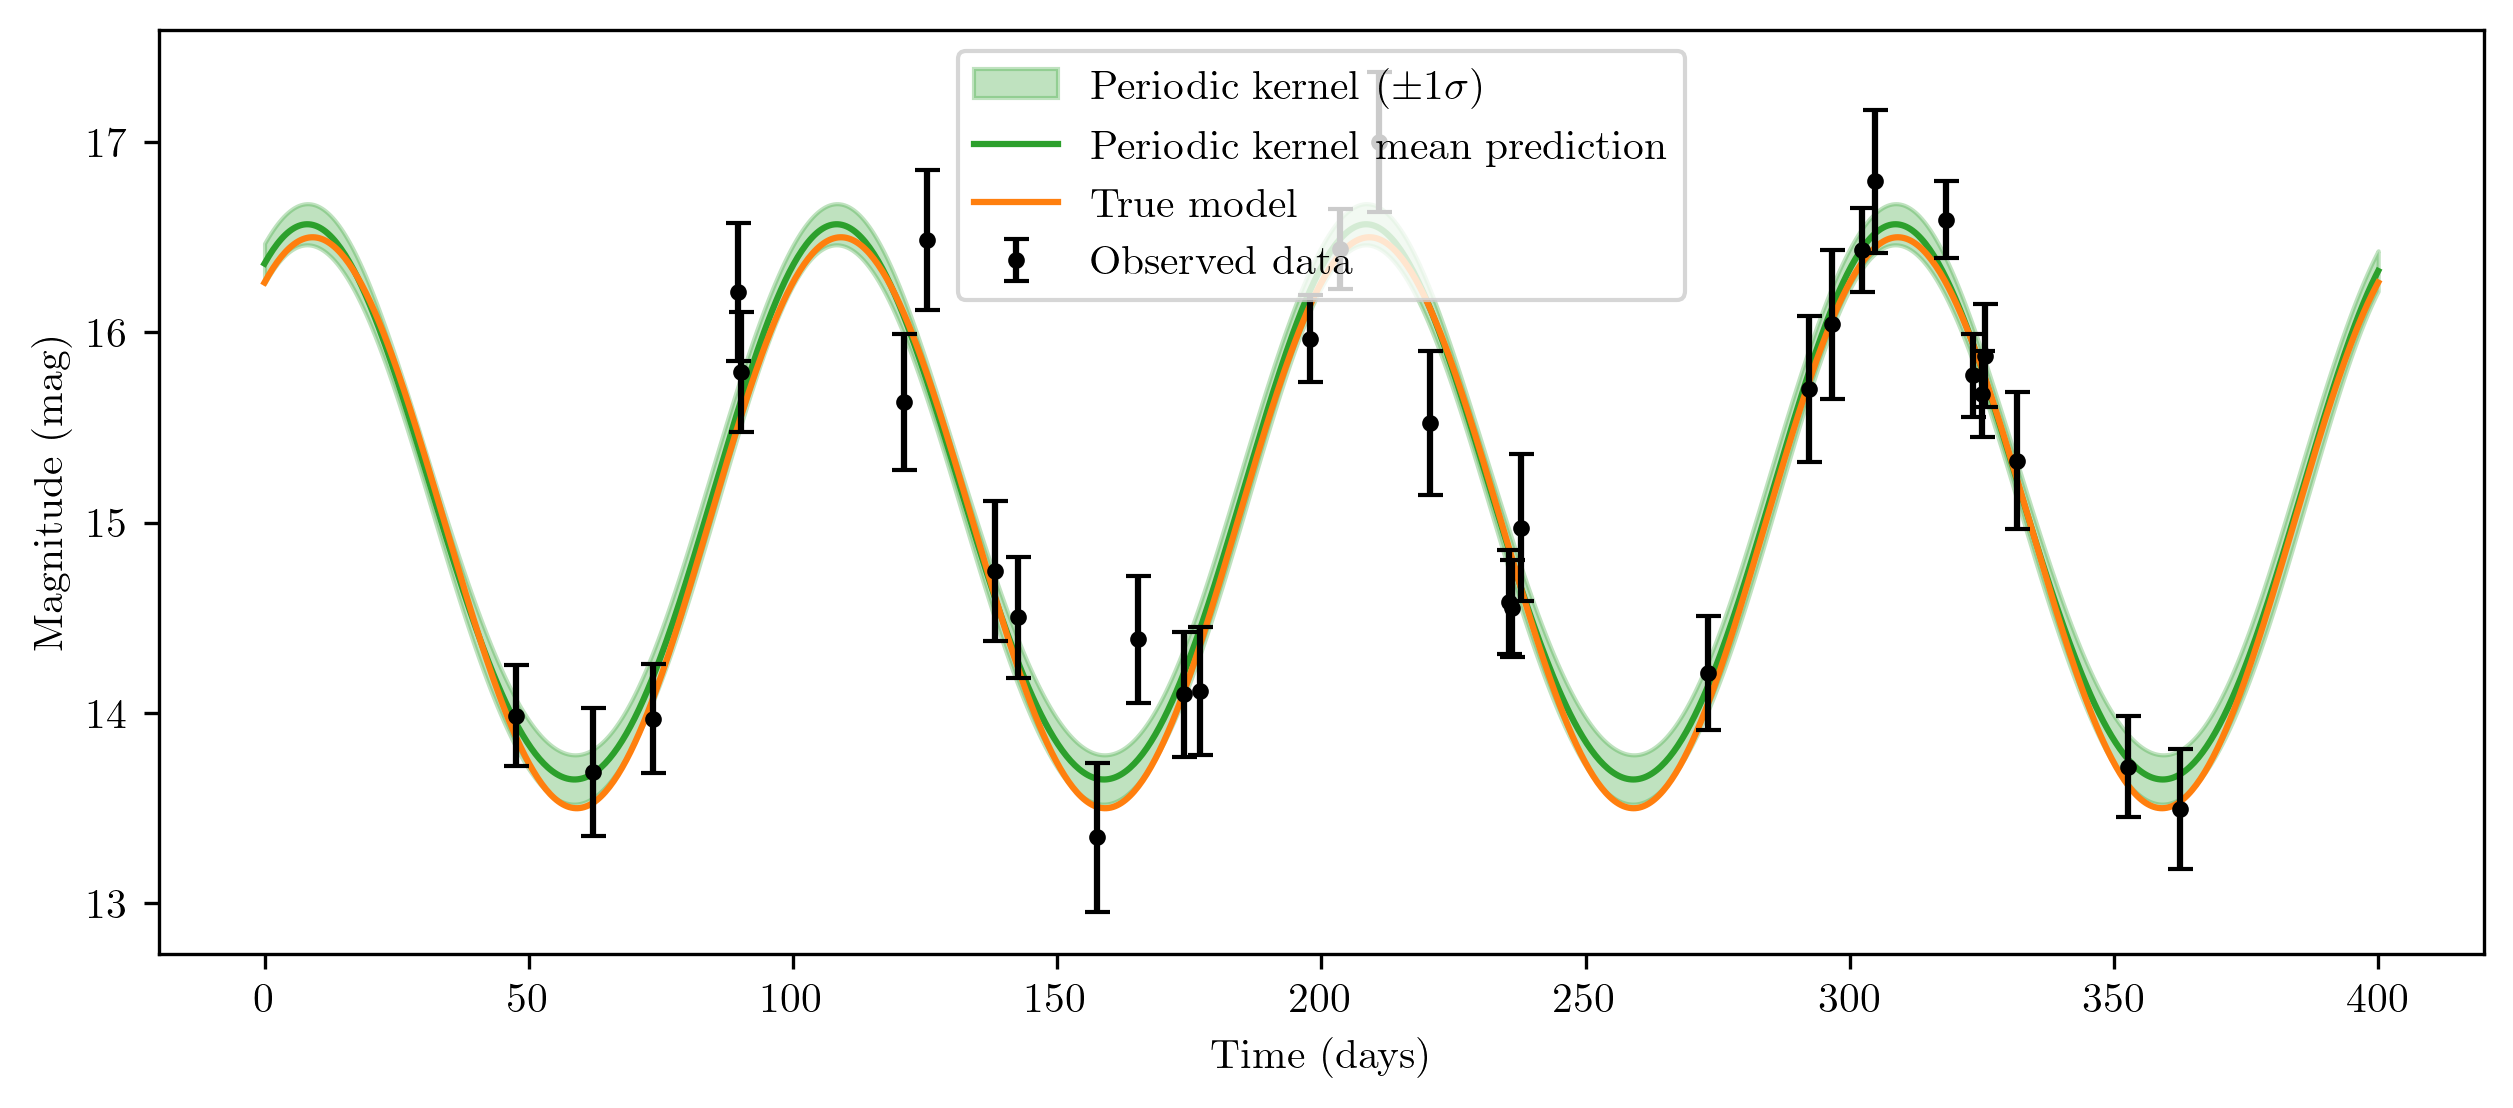

In [108]:
m_pred_full_pd, sigma_pred_full_pd = gp_pd.predict(t_full.reshape(-1, 1), return_std=True)

# Plot the predictive bands from periodic kernel
plt.figure(figsize=(10, 4))
plt.fill_between(t_full, m_pred_full_pd - sigma_pred_full_pd,
                 m_pred_full_pd + sigma_pred_full_pd,
                 color='tab:green', alpha=0.3, label=r'Periodic kernel ($\pm1\sigma$)')
plt.plot(t_full, m_pred_full_pd, color='tab:green', label='Periodic kernel mean prediction')

# Overlay the true model and simulated data
plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)

plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.legend()
plt.show()

#### Question 1.2: Basis function regression

The light curve may also be modeled by the sum of shifted basis functions:

$m(t) = m_0 + \sum\limits_{h=1}^{M} c_h B_h(t)$

where $B_h(t)$ are the basis functions and $c_h$ are the corresponding coefficients.

We consider Gaussian and trigonometric basis functions for this exercise.

1. The Gaussian basis functions are defined as:

   $B_h(t) = \exp \left[ -\dfrac{(t - t_h)^2}{2 l^2} \right]$

   where $t_h$ is the center (knot) of the $h$-th basis function and $l$ is the length scale.

   For simplicity, we set $\Delta t \equiv t_{h+1} - t_h = l$ for all $h$ in the Gaussian basis functions. So the basis functions are evenly spaced with a spacing equal to the length scale $l$.

2. The trigonometric basis functions are defined as:

   $B_h(t) = a_h \cos (2\pi h t/p) + b_h \sin (2\pi h t/p)$

   where $p$ is the period, and $a_h$ and $b_h$ are coefficients of the cosine and sine terms, respectively. We fix $p=200$ days for this exercise.


**Tasks:**
1. Using the same simulated light curve data from Question 1.1, fit the data using basis function regression using Gaussian basis functions with evenly spaced knots in $[0,400]$ days. Try $M=3, 5, 9$ basis functions, corresponding to length scales of $l=200, 100, 50$ days, respectively. Infer the coefficients $\{c_h\}$ and $m_0$ using `UltraNest`. Use flat priors for all parameters: $m_0$ in $[10, 20]$ mag and $c_h$ in $[-10, 10]$ mag.
2. Compare the prediction bands (mean ± 1σ) for each $M$ over the time range of 0 to 400 days.
3. For each $M$, infer the brightness predictions at $t=[100,200,300,400]$ days as derived parameters, plot their posterior distributions, and report the corresponding summary statistics.
4. Report the log-evidences for each $M$ and discuss which model is preferred based on the evidence.
5. Repeat the above tasks using trigonometric basis functions instead of Gaussian basis functions. Try $M=2, 3, 4$ basis functions, and use flat priors for all parameters: $m_0$ in $[10, 20]$ mag and $a_h, b_h$ in $[-10, 10]$ mag.

**Hints:**
1. It is recommended to use the `ultranest.stepsampler` module for high-dimensional problems, see https://johannesbuchner.github.io/UltraNest/example-sine-highd.html
2. You can plot the prediction bands using the `PredictiveBands` class from the `ultranest.plot` module.

In [109]:
# Functions for UltraNest inference with Gaussian basis functions
def lightcurve_gauss_basis_model(t, params):
    """Model light curve using Gaussian basis functions.
    Args:
        t: array, time array
        params: array, model parameters (m_0, c_1, c_2, ..., c_M)
    Returns:
        m_model: array, modeled magnitudes
    """
    m0, *c = params
    M = len(c)
    w = 400 // (M - 1)  # Center spacing and standard deviation of Gaussian basis functions

    # NOTE: EDIT below to compute the model magnitudes
    centers = np.linspace(0.0, 400.0, M)
    t = np.asarray(t)
    # Gaussian basis functions with std = spacing w
    # B_h(t) = exp[-0.5 * ((t - center)/w)**2]
    gauss_matrix = np.vstack([ci * np.exp(-0.5 * ((t - center) / w) ** 2)
                              for ci, center in zip(c, centers)])
    m_model = m0 + np.sum(gauss_matrix, axis=0)
    return m_model

def prior_transform_gaussian_basis(cube, param_ranges, derived_time=None):
    """Transform unit cube to parameter space for Gaussian basis functions.
    Args:
        cube: array, unit cube samples (m_0, c_1, c_2, ..., c_M)
        param_ranges: array, parameter ranges
        derived_time: array, times at which to derive parameters
    Returns:
        params: array, transformed parameters + derived parameters
    """
    params = []
    for i, (pmin, pmax) in enumerate(param_ranges):
        params.append(pmin + cube[i] * (pmax - pmin))
    # Add derived parameters if needed
    if derived_time is not None:
        m_model = lightcurve_gauss_basis_model(derived_time, params)
        params = np.concatenate([params, m_model])
    return params

def log_likelihood_gaussian_basis(params, t, m_obs, sigma, M):
    """Compute log-likelihood for Gaussian basis function model.
    Args:
        params: array, model parameters (m_0, c_1, c_2, ..., c_M)
        t: array, time array
        m_obs: array, observed magnitudes
        sigma: array, measurement uncertainties
        M: int, number of Gaussian basis functions
    Returns:
        logL: float, log-likelihood value
    """
    # NOTE: EDIT below to complete this function
    # Ensure params is an array and extract the model parameters (m0, c1...cM)
    params = np.asarray(params)
    model_params = params[:M+1]

    # Compute model magnitudes at observation times
    m_model = lightcurve_gauss_basis_model(t, model_params)

    # Check for numerical issues
    if np.any(~np.isfinite(m_model)) or np.any(~np.isfinite(m_obs)) or np.any(sigma <= 0):
        return -1e99

    # Gaussian log-likelihood (heteroscedastic errors)
    var = sigma**2
    resid = m_obs - m_model
    logL = -0.5 * np.sum(resid**2 / var + np.log(2.0 * np.pi * var))
    return logL

In [110]:
import ultranest
import ultranest.stepsampler as stepsampler

# Setup Gaussian basis functions with different numbers
num_gauss_basis = [3, 5, 9]
ultranest_results_gauss = []

derived_time = t_test
derived_truth = m_test_true
derived_names = [f'm_{ti}' for ti in derived_time]

for M in num_gauss_basis:
    pnames = ['m0'] + [f'c{i}' for i in range(1,M+1)]
    pranges = [[10,20]] + [[-10,10]] * M
    
    sampler = ultranest.ReactiveNestedSampler(
        pnames,
        lambda params: log_likelihood_gaussian_basis(params, t, m_obs, sigma, M),
        lambda cube: prior_transform_gaussian_basis(cube, pranges, derived_time=derived_time),
        derived_param_names=derived_names,
        log_dir=f'lightcurve_gauss_basis_M{M}',
        # resume=True
    )

    sampler.stepsampler = stepsampler.SliceSampler(
        nsteps=2 * (M + 1),
        generate_direction=stepsampler.generate_mixture_random_direction
    )

    results = sampler.run()
    ultranest_results_gauss.append(results)

Creating directory for new run lightcurve_gauss_basis_M3/run1


Creating directory for new run lightcurve_gauss_basis_M5/run13]*| it/evals=6913/173679 eff=3.9895% N=400  0  


Creating directory for new run lightcurve_gauss_basis_M9/run18]*| it/evals=9360/289602 eff=3.2365% N=400    


Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 2400x2400 with 0 Axes>

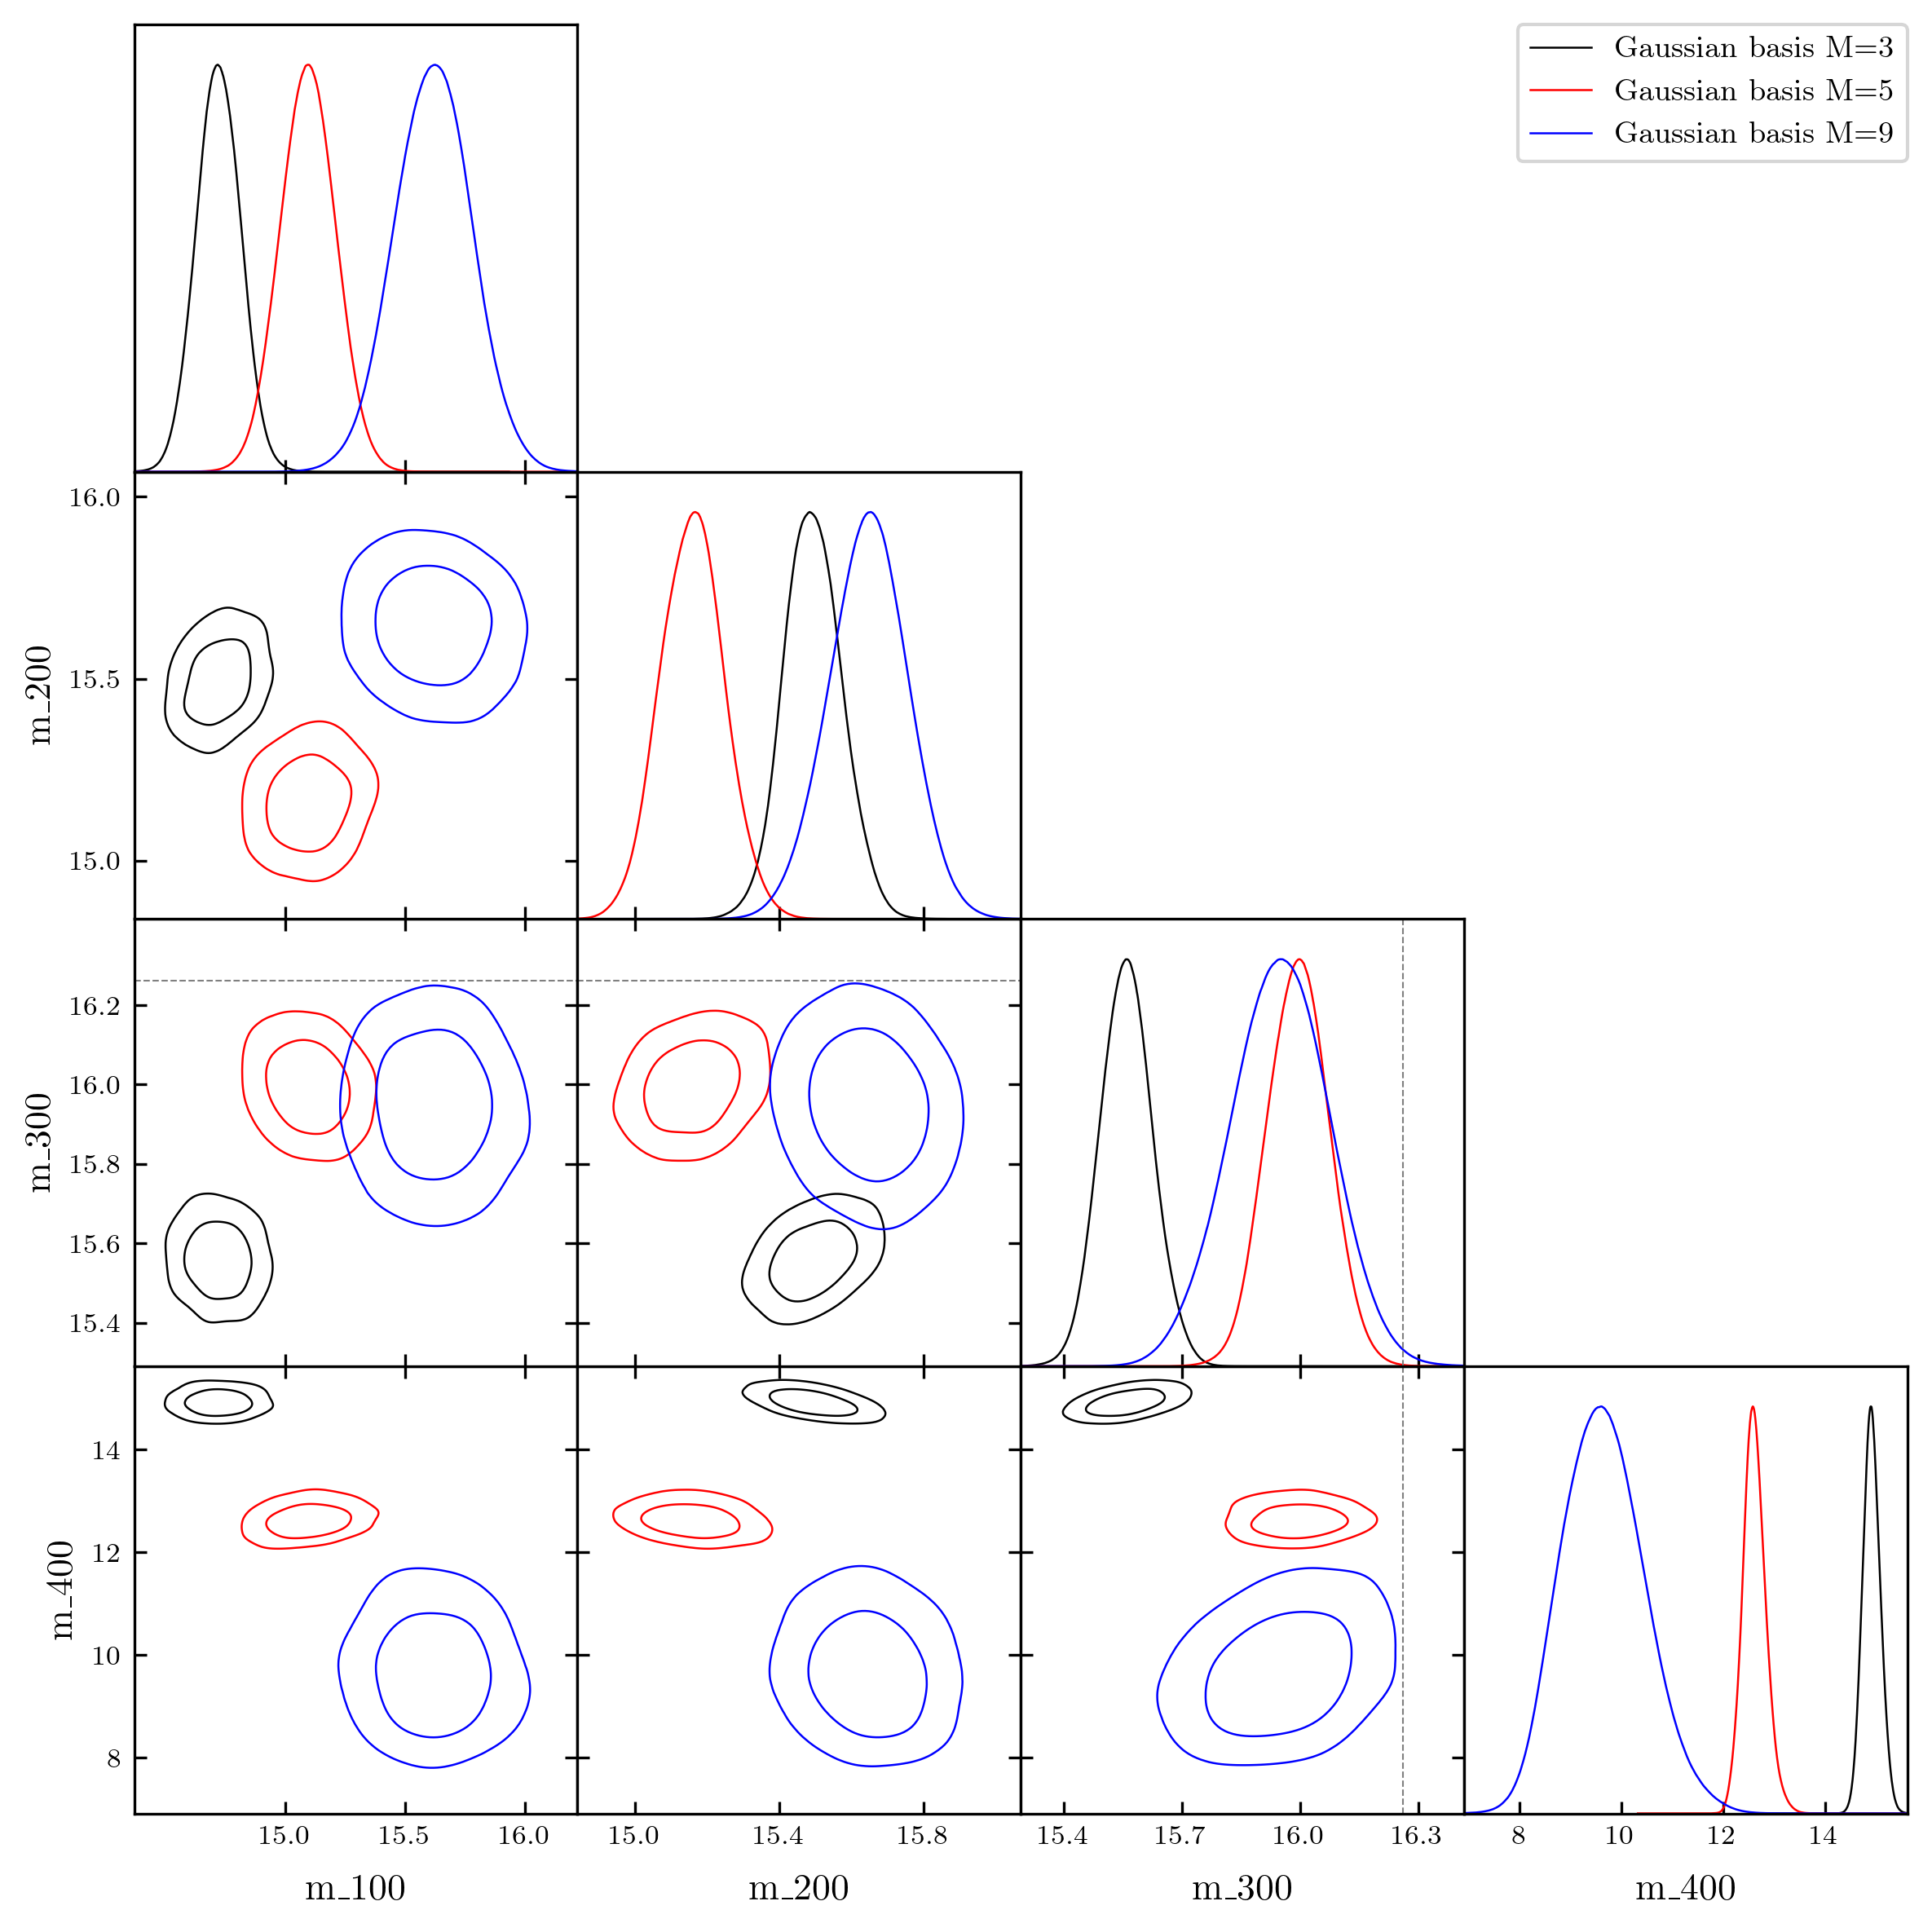

In [111]:
from getdist import plots, MCSamples

# Convert UltraNest results to GetDist MCSamples and make corner plots
getdist_gauss_samples = []

for i, M in enumerate(num_gauss_basis):
    results = ultranest_results_gauss[i]
    ws = results['weighted_samples']

    samples = MCSamples(
        samples=ws['points'][:, M+1:],
        weights=ws['weights'],
        loglikes=-ws['logl'],
        names=derived_names,
        sampler='nested'
    )

    getdist_gauss_samples.append(samples)

# Make corner plots for derived parameters using getdist
g = plots.get_single_plotter(width_inch=8, ratio=1.0)
g.triangle_plot(
    getdist_gauss_samples,
    param_names=derived_names,
    filled=False,
    markers={n:v for n,v in zip(derived_names, derived_truth)},
    legend_labels=[f'Gaussian basis M={M}' for M in num_gauss_basis],
    legend_loc='upper right'
)

In [112]:
# Report summary statistics of the derived parameters and compare with true values
for i, M in enumerate(num_gauss_basis):
    results = ultranest_results_gauss[i]
    print(f"Results for Gaussian basis functions with M={M}:")
    for j, ti in enumerate(derived_time):
        param_name = f'm_{ti}'
        mean = results['posterior']['mean'][M+1+j]
        std = results['posterior']['stdev'][M+1+j]
        rel_error = np.abs(mean - derived_truth[j]) / np.abs(derived_truth[j])
        rel_error_norm = np.abs(mean - derived_truth[j]) / std
        print(f"t = {ti:.1f} days:\n\tm = {mean:.3f} ± {std:.3f} mag (relative error = {rel_error:.2%}, normalized = {rel_error_norm:.2f} sigma)")

Results for Gaussian basis functions with M=3:
t = 100.0 days:
	m = 14.720 ± 0.092 mag (relative error = 9.48%, normalized = 16.77 sigma)
t = 200.0 days:
	m = 15.493 ± 0.079 mag (relative error = 4.73%, normalized = 9.68 sigma)
t = 300.0 days:
	m = 15.560 ± 0.066 mag (relative error = 4.32%, normalized = 10.66 sigma)
t = 400.0 days:
	m = 14.919 ± 0.173 mag (relative error = 8.26%, normalized = 7.76 sigma)
Results for Gaussian basis functions with M=5:
t = 100.0 days:
	m = 15.094 ± 0.115 mag (relative error = 7.19%, normalized = 10.17 sigma)
t = 200.0 days:
	m = 15.158 ± 0.088 mag (relative error = 6.79%, normalized = 12.50 sigma)
t = 300.0 days:
	m = 15.995 ± 0.078 mag (relative error = 1.64%, normalized = 3.43 sigma)
t = 400.0 days:
	m = 12.619 ± 0.227 mag (relative error = 22.40%, normalized = 16.02 sigma)
Results for Gaussian basis functions with M=9:
t = 100.0 days:
	m = 15.616 ± 0.160 mag (relative error = 3.98%, normalized = 4.04 sigma)
t = 200.0 days:
	m = 15.647 ± 0.108 mag (re

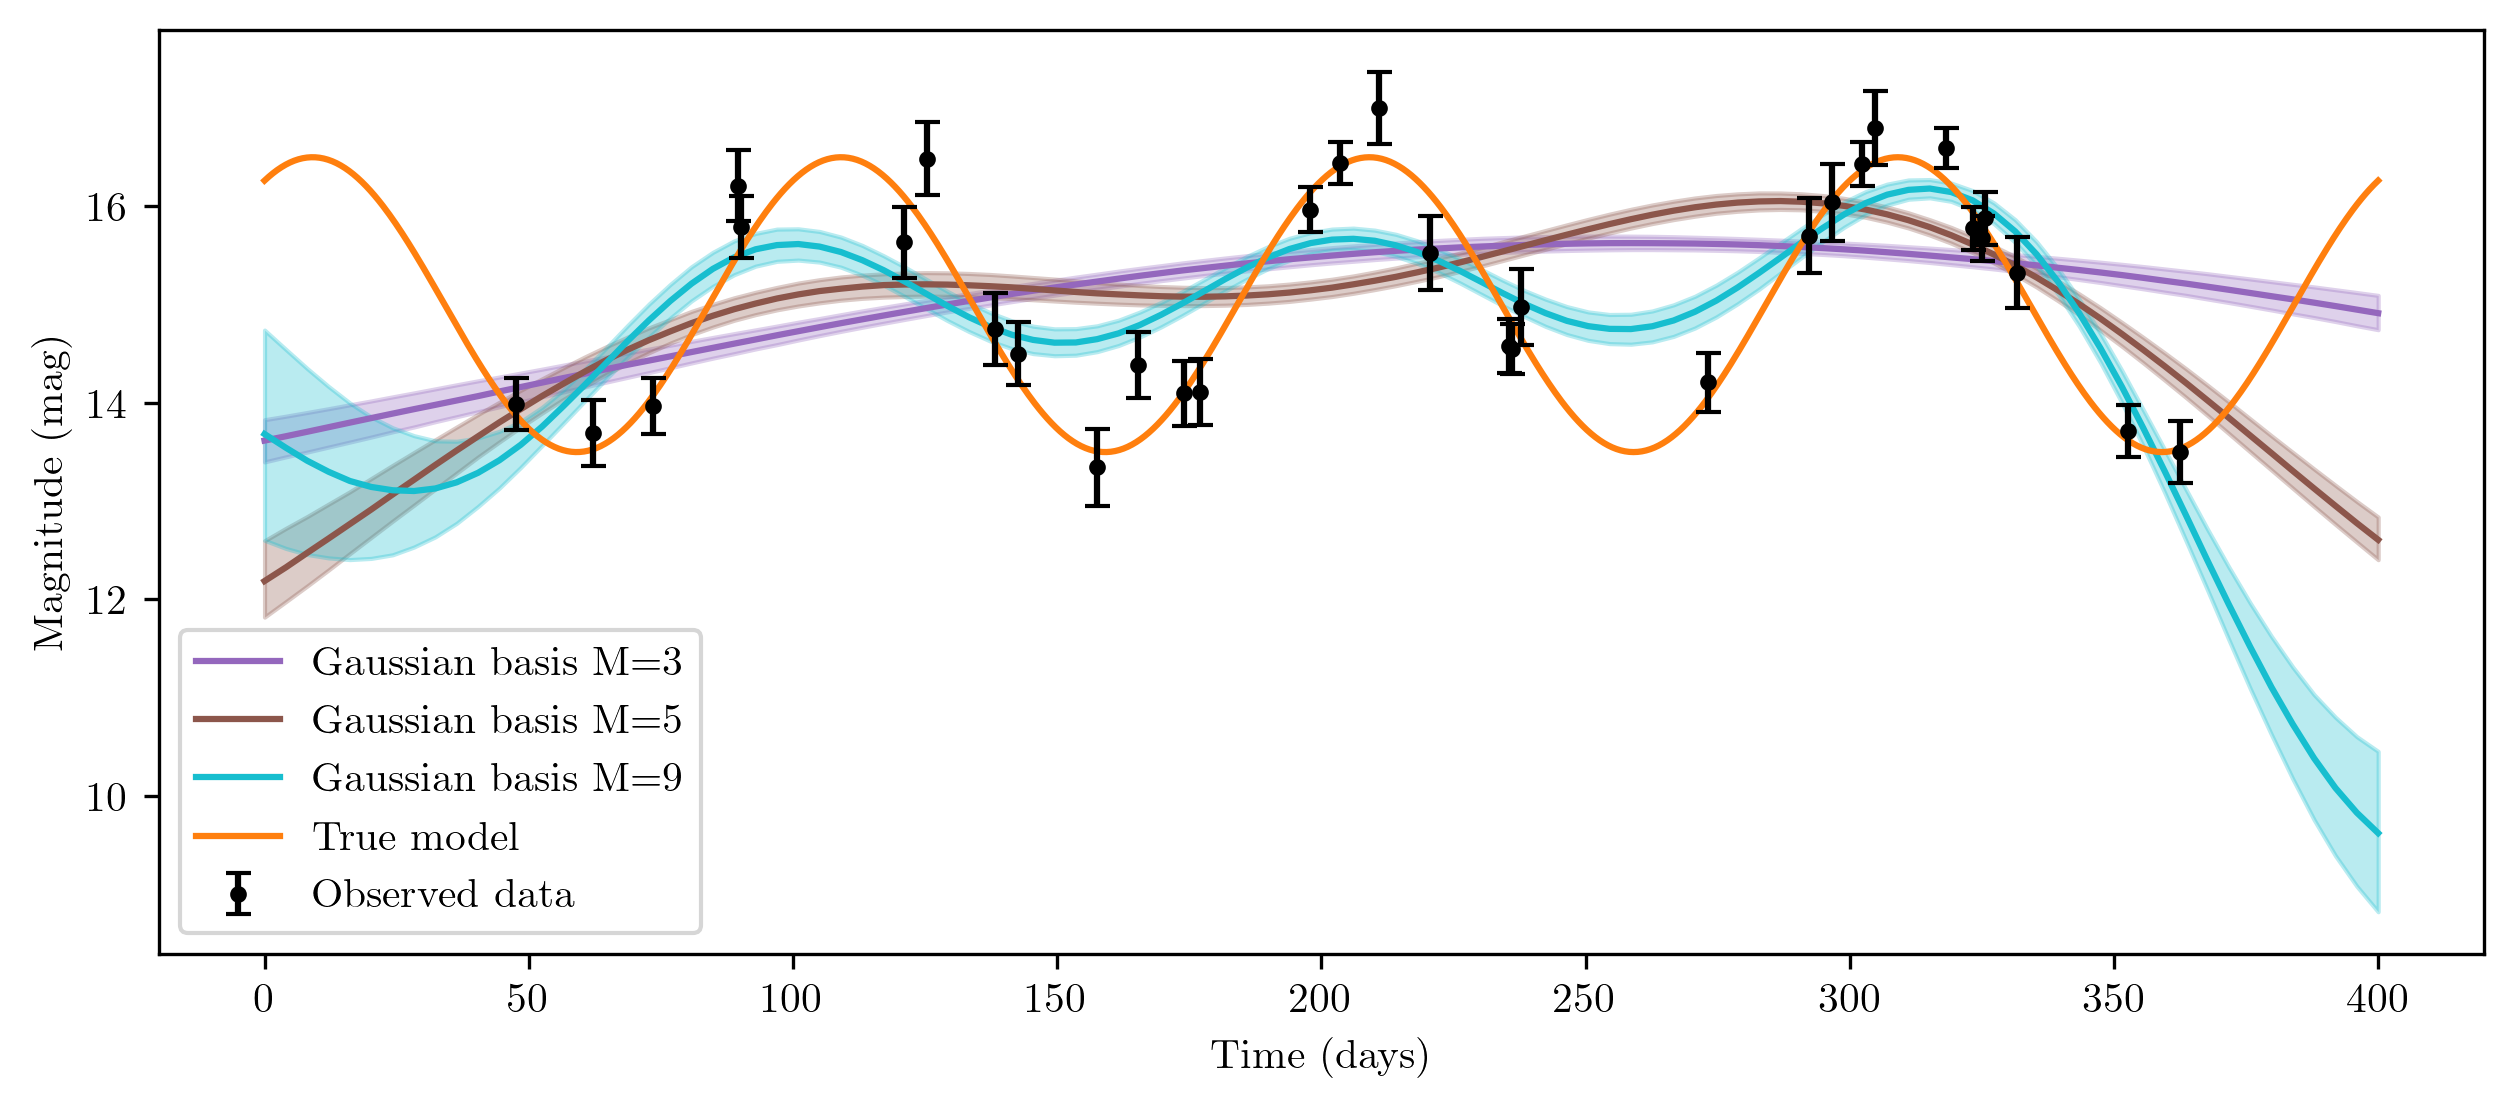

In [113]:
from ultranest.plot import PredictionBand

# Plot the predictive bands from Gaussian basis function models
plt.figure(figsize=(10, 4))
colors = ['tab:purple', 'tab:brown', 'tab:cyan']

for i, M in enumerate(num_gauss_basis):
    results = ultranest_results_gauss[i]
    t_sample = np.linspace(0, 400, 100)
    pband = PredictionBand(t_sample)
    for p in results['samples']:
        pband.add(lightcurve_gauss_basis_model(t_sample, p[:M+1]))

    pband.line(color=colors[i], label=f'Gaussian basis M={M}')
    pband.shade(color=colors[i], alpha=0.3)

# Overlay the true model and simulated data
plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.legend()
plt.show()

In [114]:
# Functions for UltraNest inference with trignometric basis functions
def lightcurve_trig_basis_model(t, params):
    """Model light curve using trignometric basis functions.
    Args:
        t: array, time array
        params: array, model parameters (m_0, p, a_1, b_1, a_2, b_2, ..., a_N, b_N)
    Returns:
        m_model: array, model magnitudes at times t
    """
    params = np.asarray(params)
    m0 = params[0]
    p = params[1]
    # determine number of harmonics
    N = (len(params) - 2) // 2
    a = params[2:2+N] if N > 0 else np.array([])
    b = params[2+N:2+2*N] if N > 0 else np.array([])
    t = np.asarray(t)
    if N == 0:
        return m0 + np.zeros_like(t)
    # sum over harmonics: h runs from 1..N
    terms = np.vstack([a_h * np.cos(2 * np.pi * (h+1) * t / p) + b_h * np.sin(2 * np.pi * (h+1) * t / p)
                       for h, (a_h, b_h) in enumerate(zip(a, b))])
    m_model = m0 + np.sum(terms, axis=0)
    return m_model

def prior_transform_trig_basis(cube, param_ranges, derived_time=None):
    """Transform unit cube to parameter space for trignometric basis functions.
    Args:
        cube: array, unit cube samples (m_0, p, a_1, b_1, a_2, b_2, ..., a_N, b_N)
        param_ranges: array, parameter ranges
        derived_time: array, times at which to derive parameters
    Returns:
        params: array, transformed parameters (and derived if requested)
    """
    params = []
    for i, (pmin, pmax) in enumerate(param_ranges):
        params.append(pmin + cube[i] * (pmax - pmin))
    params = np.array(params)
    if derived_time is not None:
        m_model = lightcurve_trig_basis_model(derived_time, params)
        params = np.concatenate([params, m_model])
    return params

def log_likelihood_trig_basis(params, t, m_obs, sigma, N):
    """Compute log-likelihood for trignometric basis function model.
    Args:
        params: array, model parameters (m_0, p, a_1, b_1, a_2, b_2, ..., a_N, b_N)
        t: array, time array
        m_obs: array, observed magnitudes
        sigma: array, measurement uncertainties
        N: int, number of trignometric basis functions
    Returns:
        logL: float, log-likelihood value
    """
    params = np.asarray(params)
    # ensure we only use the model parameters (in case derived params appended)
    model_params = params[:2 + 2 * N]
    m_model = lightcurve_trig_basis_model(t, model_params)
    # numeric checks
    if np.any(~np.isfinite(m_model)) or np.any(~np.isfinite(m_obs)) or np.any(sigma <= 0):
        return -1e99
    var = sigma**2
    resid = m_obs - m_model
    logL = -0.5 * np.sum(resid**2 / var + np.log(2.0 * np.pi * var))
    return logL

In [115]:
# Setup trignometric basis functions with different numbers
num_trig_basis = [1, 2, 3]
ultranest_results_trig = []

for M in num_trig_basis:
    pnames = ['m0','p'] + [f'a{i+1}' for i in range(M)] + [f'b{i+1}' for i in range(M)]
    pranges = [[10,20], [50,200]] + [[-10,10]] * (2 * M)
    
    # NOTE: EDIT below to setup and run the UltraNest sampler
    sampler = ultranest.ReactiveNestedSampler(
        pnames,
        lambda params: log_likelihood_trig_basis(params, t, m_obs, sigma, M),
        lambda cube: prior_transform_trig_basis(cube, pranges, derived_time=derived_time),
        derived_param_names=derived_names,
        log_dir=f'lightcurve_trig_basis_M{M}',
        # resume=True
    )

    sampler.stepsampler = stepsampler.SliceSampler(
        nsteps=2 * (M + 1),
        generate_direction=stepsampler.generate_mixture_random_direction
    )

    results = sampler.run()
    ultranest_results_trig.append(results)

Creating directory for new run lightcurve_trig_basis_M1/run1


Creating directory for new run lightcurve_trig_basis_M2/run1evals=8760/159670 eff=5.5001% N=400         0    


Creating directory for new run lightcurve_trig_basis_M3/run1evals=12240/324722 eff=3.7740% N=400   0    0  0  


Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 1800x1800 with 0 Axes>

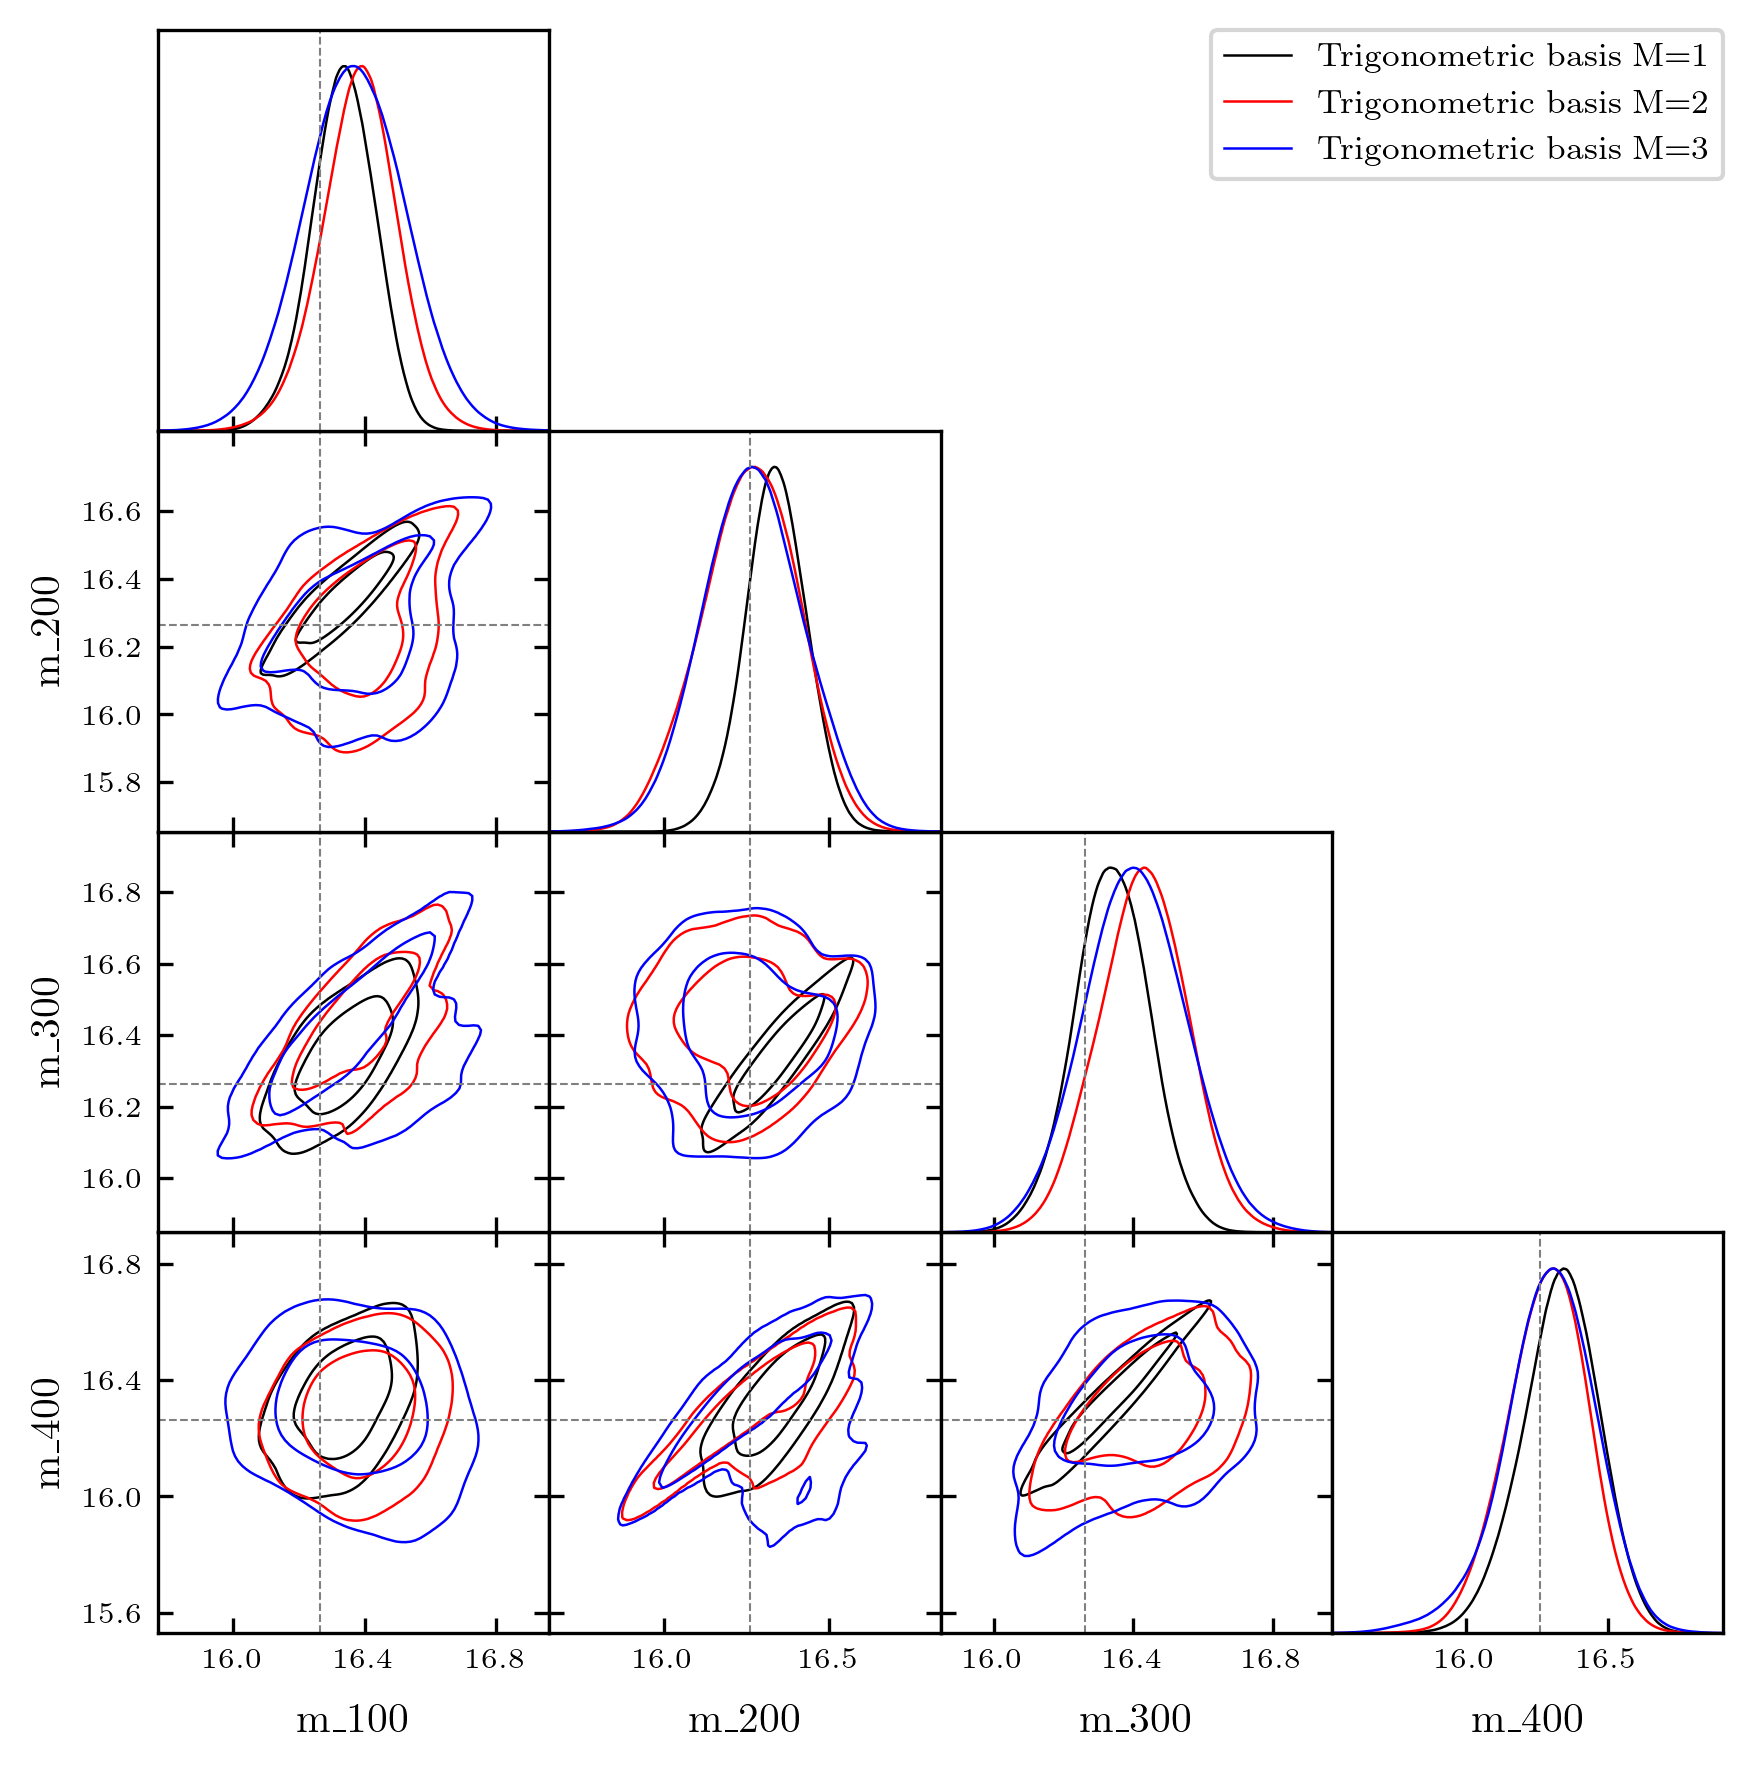

In [116]:
# Convert UltraNest results to GetDist MCSamples and make corner plots
getdist_trig_samples = []
for i, M in enumerate(num_trig_basis):
    results = ultranest_results_trig[i]
    
    # NOTE: EDIT below to convert UltraNest results to GetDist MCSamples
    ws = results['weighted_samples']
    start_idx = 2 + 2 * M  # m0, p, then 2*M a/b parameters
    samples = MCSamples(
        samples=ws['points'][:, start_idx:],
        weights=ws['weights'],
        loglikes=-ws['logl'],
        names=derived_names,
        sampler='nested'
    )

    getdist_trig_samples.append(samples)

# Make corner plots for derived parameters using getdist
g = plots.get_single_plotter(width_inch=6, ratio=1.0)
g.triangle_plot(
    getdist_trig_samples,
    param_names=derived_names,
    filled=False,
    markers={n:v for n,v in zip(derived_names, derived_truth)},
    legend_labels=[f'Trigonometric basis M={M}' for M in num_trig_basis],
    legend_loc='upper right'
)

In [117]:
# Report summary statistics of the derived parameters and compare with true values
for i, M in enumerate(num_trig_basis):
    results = ultranest_results_trig[i]
    print(f"Results for Trignometric basis functions with M={M}:")
    for j, ti in enumerate(derived_time):
        param_name = f'm_{ti}'
        mean = results['posterior']['mean'][2*M+2+j]
        std = results['posterior']['stdev'][2*M+2+j]
        rel_error = np.abs(mean - derived_truth[j]) / np.abs(derived_truth[j])
        rel_error_norm = np.abs(mean - derived_truth[j]) / std
        print(f"t = {ti:.1f} days:\n\tm = {mean:.3f} ± {std:.3f} mag (relative error = {rel_error:.2%}, normalized = {rel_error_norm:.2f} sigma)")

Results for Trignometric basis functions with M=1:
t = 100.0 days:
	m = 16.334 ± 0.097 mag (relative error = 0.44%, normalized = 0.75 sigma)
t = 200.0 days:
	m = 16.338 ± 0.092 mag (relative error = 0.47%, normalized = 0.83 sigma)
t = 300.0 days:
	m = 16.338 ± 0.108 mag (relative error = 0.47%, normalized = 0.70 sigma)
t = 400.0 days:
	m = 16.333 ± 0.137 mag (relative error = 0.44%, normalized = 0.52 sigma)
Results for Trignometric basis functions with M=2:
t = 100.0 days:
	m = 16.383 ± 0.116 mag (relative error = 0.74%, normalized = 1.04 sigma)
t = 200.0 days:
	m = 16.260 ± 0.145 mag (relative error = 0.02%, normalized = 0.02 sigma)
t = 300.0 days:
	m = 16.428 ± 0.126 mag (relative error = 1.02%, normalized = 1.31 sigma)
t = 400.0 days:
	m = 16.287 ± 0.141 mag (relative error = 0.15%, normalized = 0.17 sigma)
Results for Trignometric basis functions with M=3:
t = 100.0 days:
	m = 16.369 ± 0.154 mag (relative error = 0.66%, normalized = 0.69 sigma)
t = 200.0 days:
	m = 16.269 ± 0.149 m

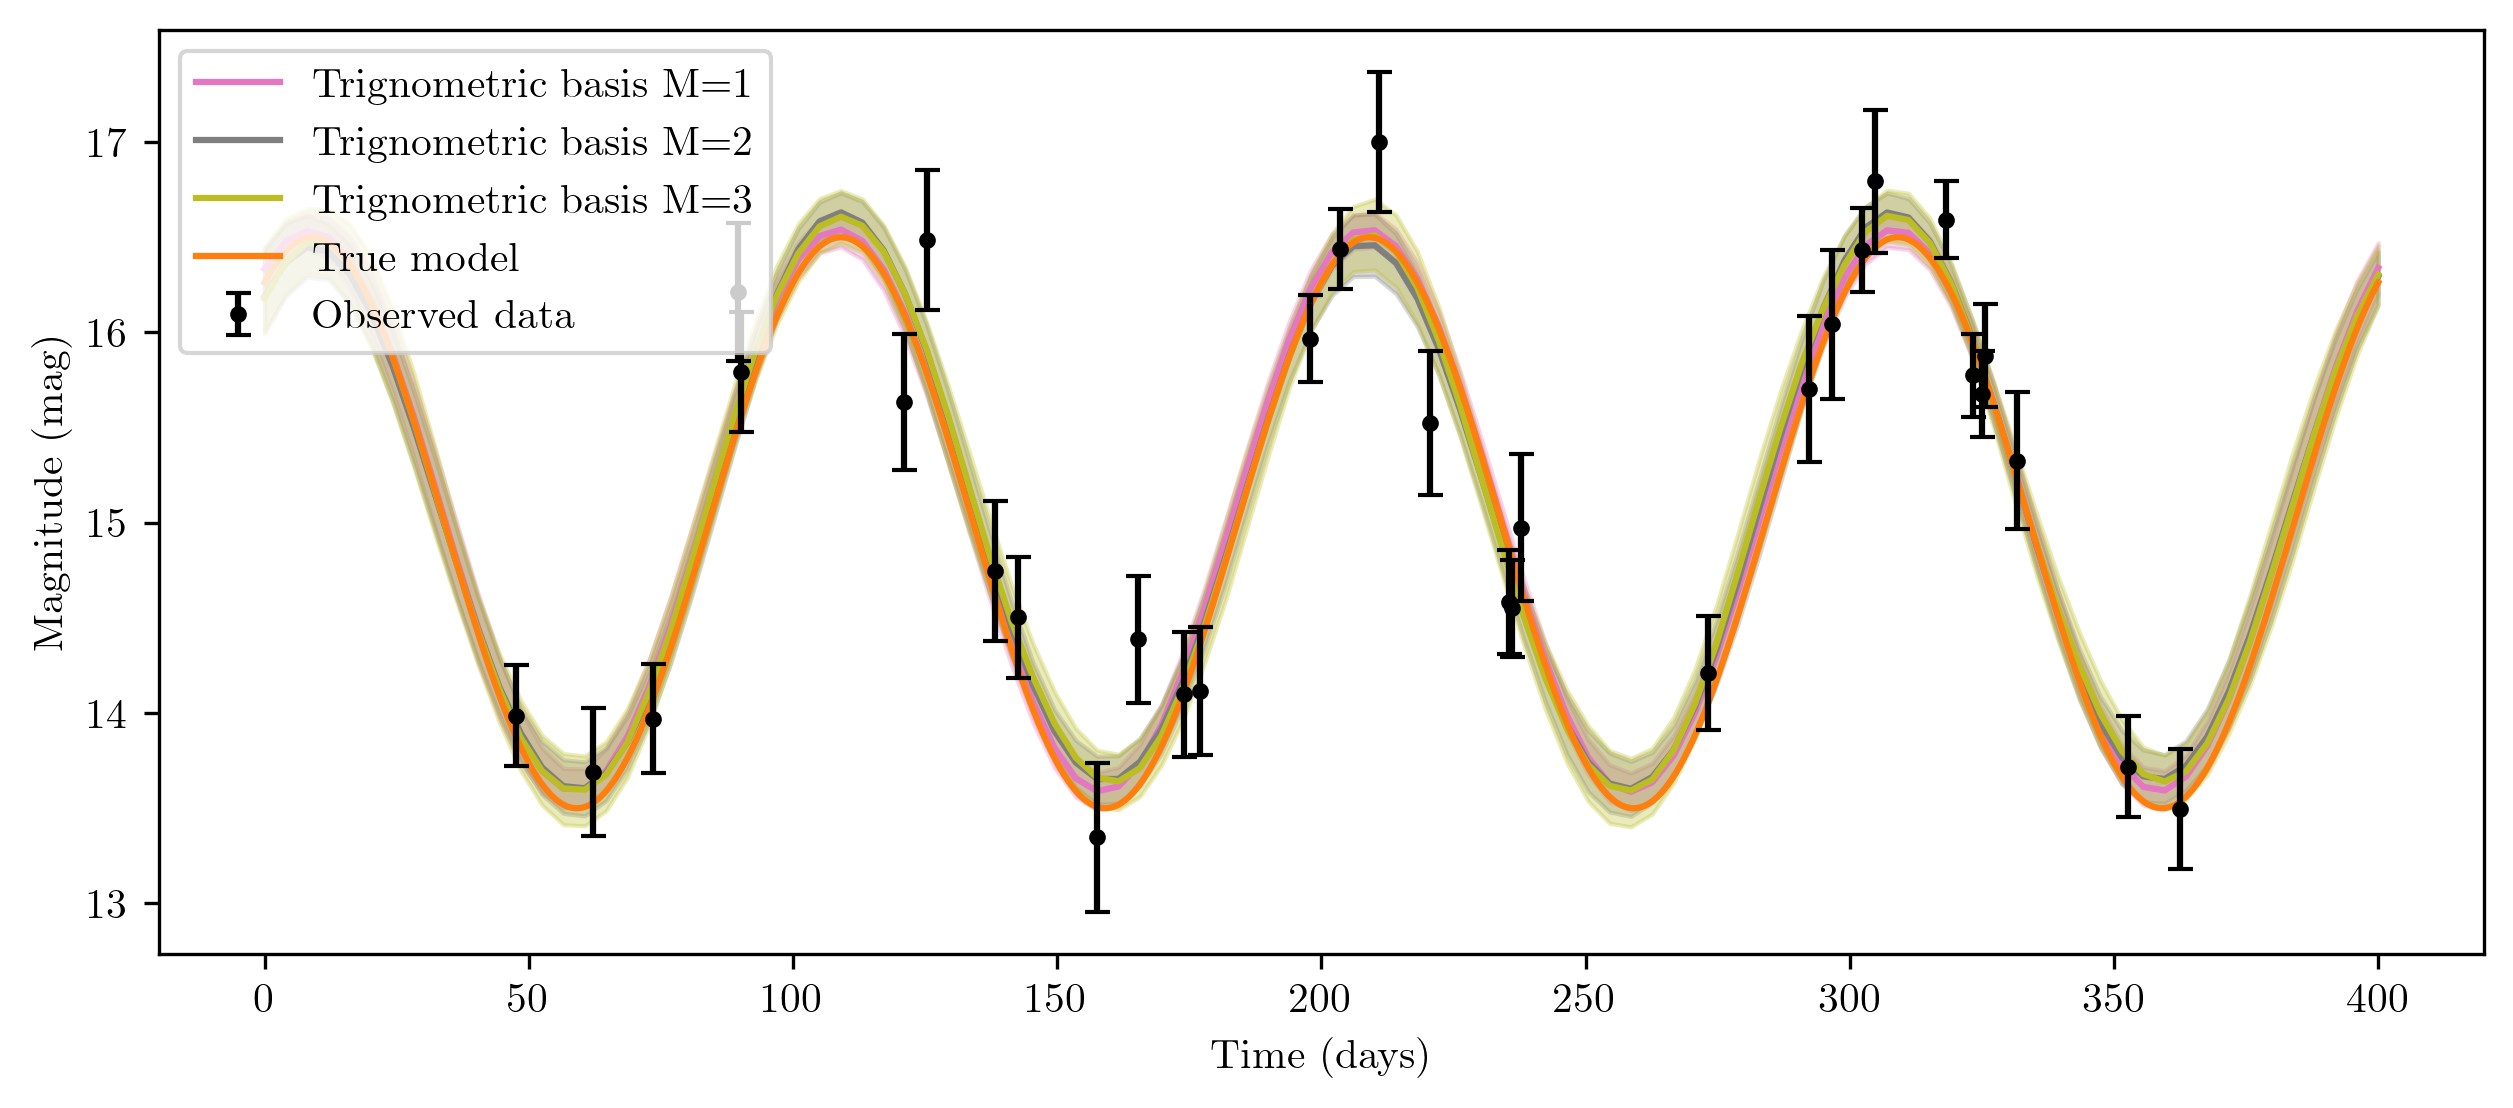

In [118]:
# Plot the predictive bands from Trignometric basis function models
plt.figure(figsize=(10, 4))
colors = ['tab:pink', 'tab:gray', 'tab:olive']

for i, M in enumerate(num_trig_basis):
    results = ultranest_results_trig[i]
    t_sample = np.linspace(0, 400, 100)
    pband = PredictionBand(t_sample)
    for p in results['samples']:
        pband.add(lightcurve_trig_basis_model(t_sample, p[:2*M+2]))

    pband.line(color=colors[i], label=f'Trignometric basis M={M}')
    pband.shade(color=colors[i], alpha=0.3)

# Overlay the true model and simulated data
plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.legend()
plt.show()

In [119]:
# Do not forget to compare the evidences
# Do not forget to compare the evidences
for i, M in enumerate(num_gauss_basis):
    print(ultranest_results_gauss[i]['logz'])

for i, M in enumerate(num_trig_basis):
    print(ultranest_results_trig[i]['logz'])

-177.89629023816784
-148.2191580210553
-85.90910791660443
-23.25778333918157
-30.92907570403099
-39.70127732542821


#### Question 1.3: prediction with parametric model

**Tasks:**
1. Assume the sinusoidal model is known, fit the simulated light curve data using `UltraNest`. Use uniform priors over the following ranges:
   - $A \in [0, 3]$ mag
   - $T \in [10, 300]$ days
   - $\phi \in [0, 2\pi]$ rad
   - $m_0 \in [10, 20]$ mag
2. Infer the brighness predictions at $t=[100,200,300,400]$ days as derived parameters.
3. Report summary statistics of the inferred parameters, and the log-evidence of the model.
4. Plot the prediction bands (mean ± 1σ) over the time range of 0 to 400 days.
5. Compare your results with those from Questions 1.1 and 1.2, and discuss your findings (such as the advantages and disadvantages of each method) for this problem.

In [120]:
# Functions for UltraNest inference with the true parametric model
def prior_transform_lightcurve(cube, param_ranges, derived_time=None):
    """Transform unit cube to uniform prior space.
    Args:
        cube: array, unit cube samples
        param_ranges: array, parameter ranges
        derived_time: array, times at which to derive parameters
    Returns:
        params: array, transformed parameters
    """
    # NOTE: EDIT below to complete this function
    params = []
    cube = np.asarray(cube)
    for i, (pmin, pmax) in enumerate(param_ranges):
        params.append(pmin + cube[i] * (pmax - pmin))
    params = np.array(params)
    if derived_time is not None:
        # append model predictions at derived_time as derived parameters
        m_derived = lightcurve_model(derived_time, *params[:len(param_ranges)])
        params = np.concatenate([params, m_derived])
    return params

def log_likelihood_lightcurve(params, t, m_obs, sigma):
    """Compute the log-likelihood of the observed data given the model parameters.
    Args:
        params: array, model parameters [A, T, phi, m0]
        t: array, time array
        m_obs: array, observed magnitudes
        sigma: array, measurement uncertainties
    Returns:
        logL: float, log-likelihood value
    """
    # NOTE: EDIT below to complete this function
    params = np.asarray(params)
    # Ensure we only use the first four entries as model parameters
    if params.size < 4:
        return -1e99
    A, T, phi, m0 = params[:4]

    # Compute model magnitudes
    m_model = lightcurve_model(t, A, T, phi, m0)

    # Numerical checks
    if np.any(~np.isfinite(m_model)) or np.any(~np.isfinite(m_obs)) or np.any(sigma <= 0):
        return -1e99

    var = sigma**2
    resid = m_obs - m_model
    logL = -0.5 * np.sum(resid**2 / var + np.log(2.0 * np.pi * var))
    return logL

In [121]:
param_names = ['A', 'T', 'phi', 'm0']
param_true = [1.5, 100, 1.0, 15.0]
param_ranges = np.array([(0, 3), (10, 300), (0, 2*np.pi), (10, 20)])

log_dir = 'lightcurve_true_model'

# NOTE: EDIT below to setup the UltraNest sampler
sampler = ultranest.ReactiveNestedSampler(
    param_names,
    lambda params: log_likelihood_lightcurve(params, t, m_obs, sigma),
    lambda cube: prior_transform_lightcurve(cube, param_ranges, derived_time=derived_time),
    derived_param_names=derived_names,
    log_dir=log_dir,
)

sampler.stepsampler = stepsampler.SliceSampler(
    nsteps=2 * len(param_names),
    generate_direction=stepsampler.generate_mixture_random_direction
)

results_parametric = sampler.run()

Creating directory for new run lightcurve_true_model/run1


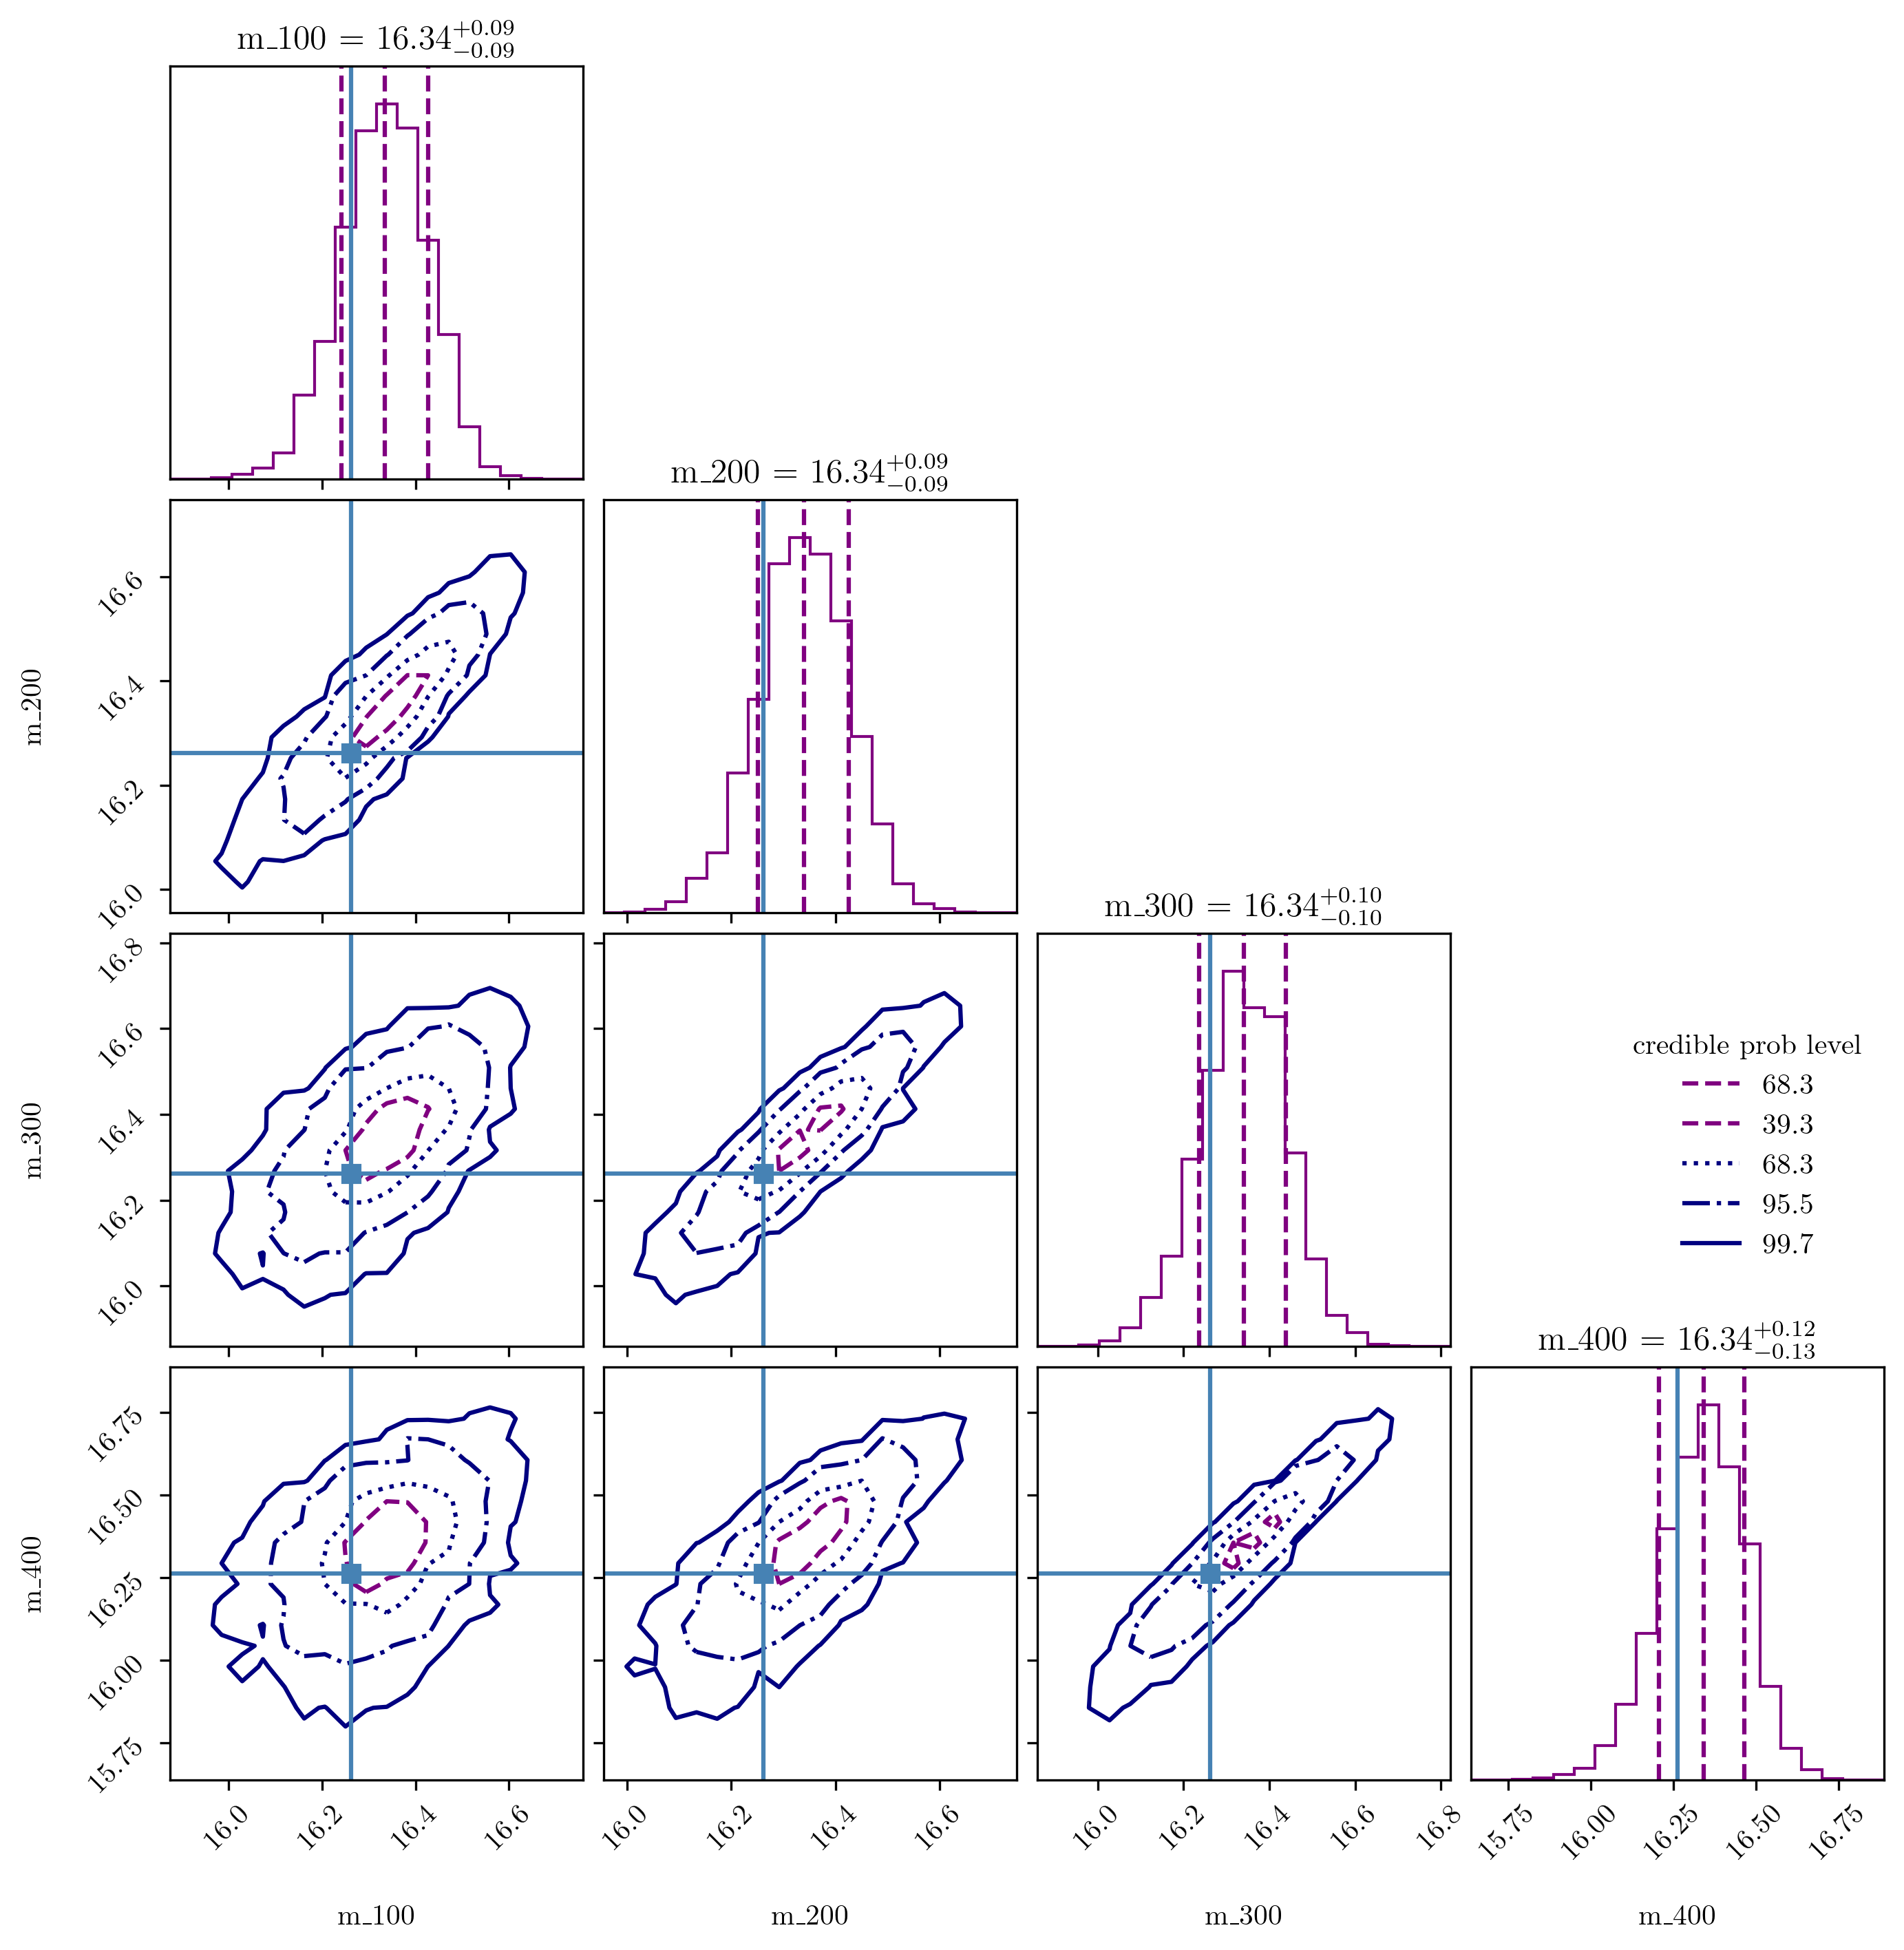

In [122]:
# Make corner plot for the derived parameters
from ultranest.plot import cornerplot

results_parametric_derived  = {
    'paramnames': derived_names,
    'weighted_samples': {
        'points': results_parametric['weighted_samples']['points'][:, 4:],
        'weights': results_parametric['weighted_samples']['weights']
    }
}
cornerplot(results_parametric_derived, truths=derived_truth)
pass

In [123]:
# Report summary statistics of the derived parameters and compare with true values
print(f"Results for True parametric model:")
for j, ti in enumerate(derived_time):
    param_name = f'm_{ti}'
    mean = results_parametric['posterior']['mean'][4+j]
    std = results_parametric['posterior']['stdev'][4+j]
    rel_error = np.abs(mean - derived_truth[j]) / np.abs(derived_truth[j])
    rel_error_norm = np.abs(mean - derived_truth[j]) / std
    print(f"t = {ti:.1f} days:\n\tm = {mean:.3f} ± {std:.3f} mag (relative error = {rel_error:.2%}, normalized = {rel_error_norm:.2f} sigma)")

Results for True parametric model:
t = 100.0 days:
	m = 16.333 ± 0.093 mag (relative error = 0.44%, normalized = 0.76 sigma)
t = 200.0 days:
	m = 16.338 ± 0.088 mag (relative error = 0.46%, normalized = 0.86 sigma)
t = 300.0 days:
	m = 16.339 ± 0.102 mag (relative error = 0.47%, normalized = 0.75 sigma)
t = 400.0 days:
	m = 16.335 ± 0.129 mag (relative error = 0.45%, normalized = 0.57 sigma)


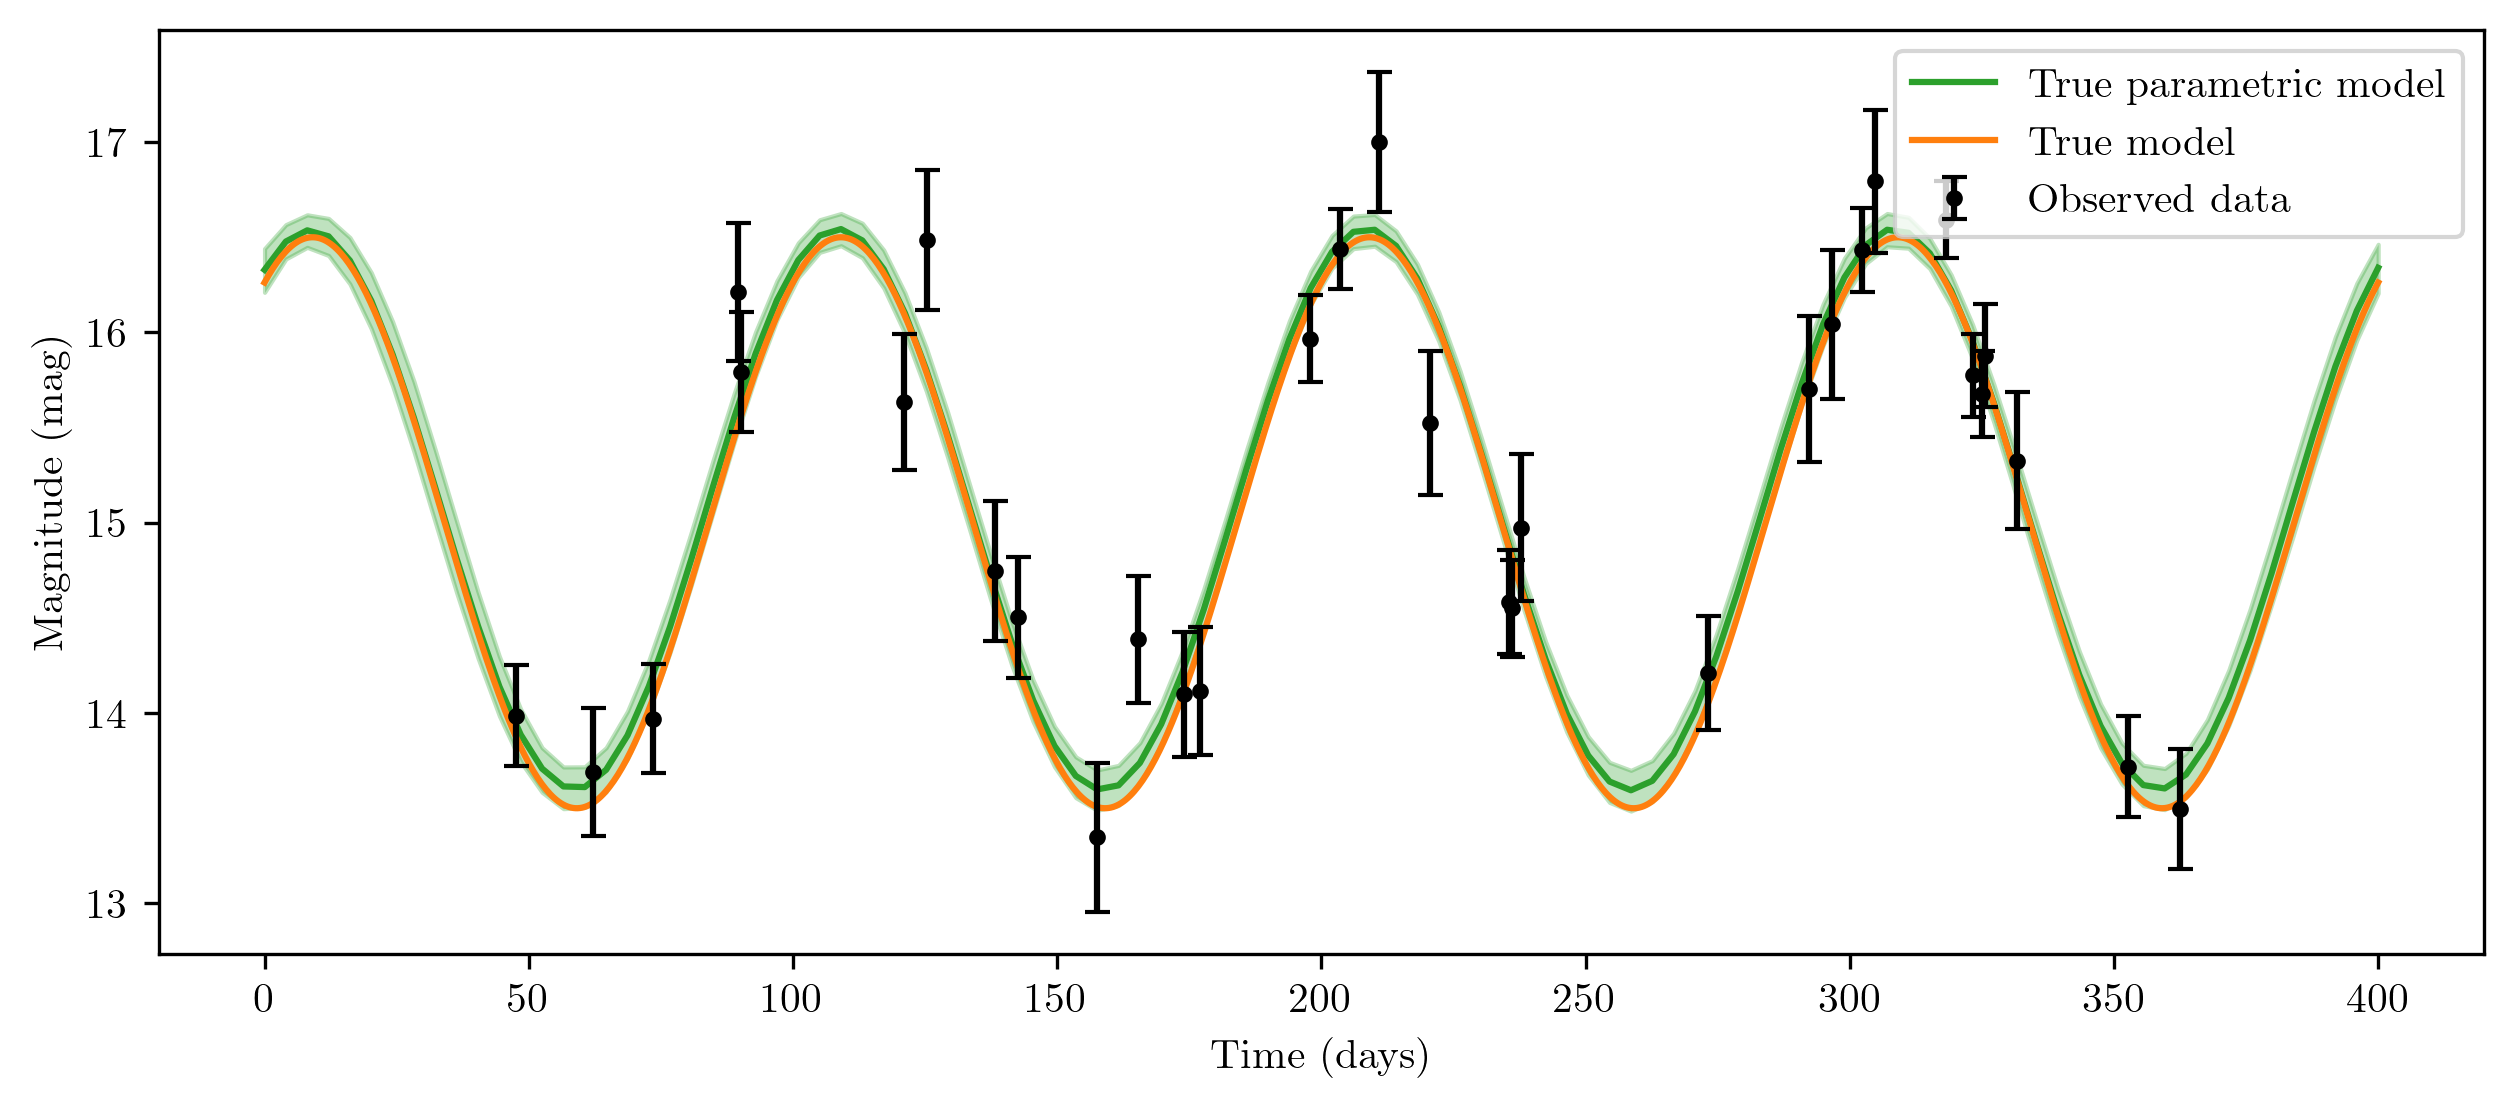

In [124]:
# Plot predictive bands from the true parametric model
plt.figure(figsize=(10, 4))
t_sample = np.linspace(0, 400, 100)
pband = PredictionBand(t_sample)
for p in results_parametric['samples']:
    pband.add(lightcurve_model(t_sample, *p[:4]))

pband.line(color='tab:green', label='True parametric model')
pband.shade(color='tab:green', alpha=0.3)

# Overlay the true model and simulated data
plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.errorbar(t, m_obs, yerr=sigma, fmt='.', label='Observed data', color='k', capsize=3)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude (mag)')
plt.legend()
plt.show()

##### Discussions

用三角函数作为 kernel 对目标函数的限制范围明显优于用 Gaussian kernel. 这表明取 kernel 的时候应该考虑真实的函数应该是什么类型.

### Exercise 2: Lorentzian absorption line

A single Lorentzian absorption line on a flat continuum can be described by the following model:

$\mu(\lambda; A, \lambda_0, \gamma, C) = C - \dfrac{A}{\pi} \dfrac{\gamma}{(\lambda - \lambda_0)^2 + \gamma^2}$

where $A$ characterizes the area removed by the absorption line (photons), $\lambda_0$ is the line center ($\AA$), $\gamma$ is the scale parameter of the Lorentzian profile ($\AA$), and $C$ is the continuum level (${\rm photon}\,\AA^{-1}$).

The equivalent width (EW) of the absorption line is:

$W = \displaystyle\int \left( 1 - \dfrac{\mu(\lambda)}{C} \right) d\lambda = \dfrac{A}{C} \,[\AA]$

Consider a Lyman-$\alpha$ absorption line with true parameters: $A=400$ photons, $\lambda_0=1215.67\,\AA$, $\gamma=0.8\,\AA$, and $C=200\,{\rm photon}\,\AA^{-1}$. The true equivalent width is thus $W=2.0\,\AA$.

Simulate $N=51$ wavelength bins uniformly distributed in the wavelength range of $[\lambda_{\rm min}, \lambda_{\rm max}] = [1210, 1220]\,\AA$ (including the endpoints) with spacing $\Delta \lambda = 0.2\,\AA$. Treat each observed count $n_i$ as an independent Poisson random variable with mean $\mu(\lambda_i) \Delta \lambda$.

#### Question 2.1: naive estimation of line properties

When the true line profile is unknown, we may naively estimate the line properties directly from the observed counts using simple integration, without relying on any model fitting.

We can estimate the continuum level $\hat{C}$ by taking the average of the observed fluxes at the two ends of the spectrum (first 5 and last 5 data points). The deficits (or photons removed due to the absorption line) at each wavelength bin is given by:

$d_i = \hat{C} - n_i / \Delta \lambda$

The line center and equivalent width can then be estimated as:

$\hat{\lambda}_0 = \dfrac{\int_{\lambda_{\rm min}}^{\lambda_{\rm max}} \lambda_i d_i \,{\rm d}\lambda}{\int_{\lambda_{\rm min}}^{\lambda_{\rm max}} d_i \,{\rm d}\lambda}$

$\hat{W} = \dfrac{\int_{\lambda_{\rm min}}^{\lambda_{\rm max}} d_i \,{\rm d}\lambda}{\hat{C}}$



**Tasks:**

1. Simulate the observed spectrum $\{(\lambda_i, n_i)\}$ using the true model parameters. Plot the simulated spectrum along with the true model.
2. Estimate the continuum level $\hat{C}$, line center $\hat{\lambda}_0$, and equivalent width $\hat{W}$ using the naive integration method described above, and report their relative errors compared to the true values.

In [125]:
# Functions for the spectral model and simulation
def spec_model(lam, A, lam0, gamma, C):
    """ Spectral model of a Lorentzian absorption line on a flat continuum.
    Args:
        lam: array, wavelength array with fixed spacing [Angstrom]
        dlam: float, wavelength spacing [Angstrom]
        A: float, area of the absorption line [photon counts]
        lam0: float, central wavelength of the absorption line [Angstrom]
        gamma: float, scale parameter of the absorption line [Angstrom]
        C: float, continuum level [photon counts per Angstrom]
    Returns:
        n: array, spectral model [expected photon counts per wavelength bin]"""
    n = C - (A / np.pi) * gamma / ((lam - lam0)**2 + gamma**2)
    return n

def sim_spec(ndata, A=80, lam0=1215.67, gamma=0.8, C=200, lam_range=[1210,1220], seed=42):
    """ Simulate a spectrum with Poisson noise.
    Args:
        ndata: int, number of data points
        A: float, area of the absorption line [photon counts]
        lam0: float, central wavelength of the absorption line [Angstrom]
        gamma: float, scale parameter of the absorption line [Angstrom]
        C: float, continuum level [photon counts per Angstrom]
        lam_range: list, wavelength range [Angstrom]
        seed: int, random seed for reproducibility
    Returns:
        lam: array, wavelength array [Angstrom]
        n_obs: array, observed photon counts
    """
    lam = np.linspace(lam_range[0], lam_range[1], ndata)
    dlam = (lam_range[1] - lam_range[0]) / (ndata - 1)
    n_true = spec_model(lam, A, lam0, gamma, C)
    rng = np.random.default_rng(seed)
    n_obs = rng.poisson(n_true * dlam)
    return lam, n_obs

In [ ]:
# Set the random seed
seed = 2024011182  # NOTE: EDIT HERE to insert your seed

# Setup parameters
nspec = 51
lam_range = [1210, 1220]
dlam = (lam_range[1] - lam_range[0]) / (nspec - 1)
param_spec_names = ['A', 'lam0', 'gamma', 'C']
param_spec_true = [400, 1215.67, 0.8, 200]
lam0_true = param_spec_true[1]
W_true = param_spec_true[0] / param_spec_true[3]

# Simulate the spectrum
lam, n_obs = sim_spec(nspec, *param_spec_true, lam_range=lam_range, seed=seed)

x_model = np.linspace(1210, 1220, 1000)
y_model = spec_model(x_model, *param_spec_true) * dlam  # Convert to counts per bin

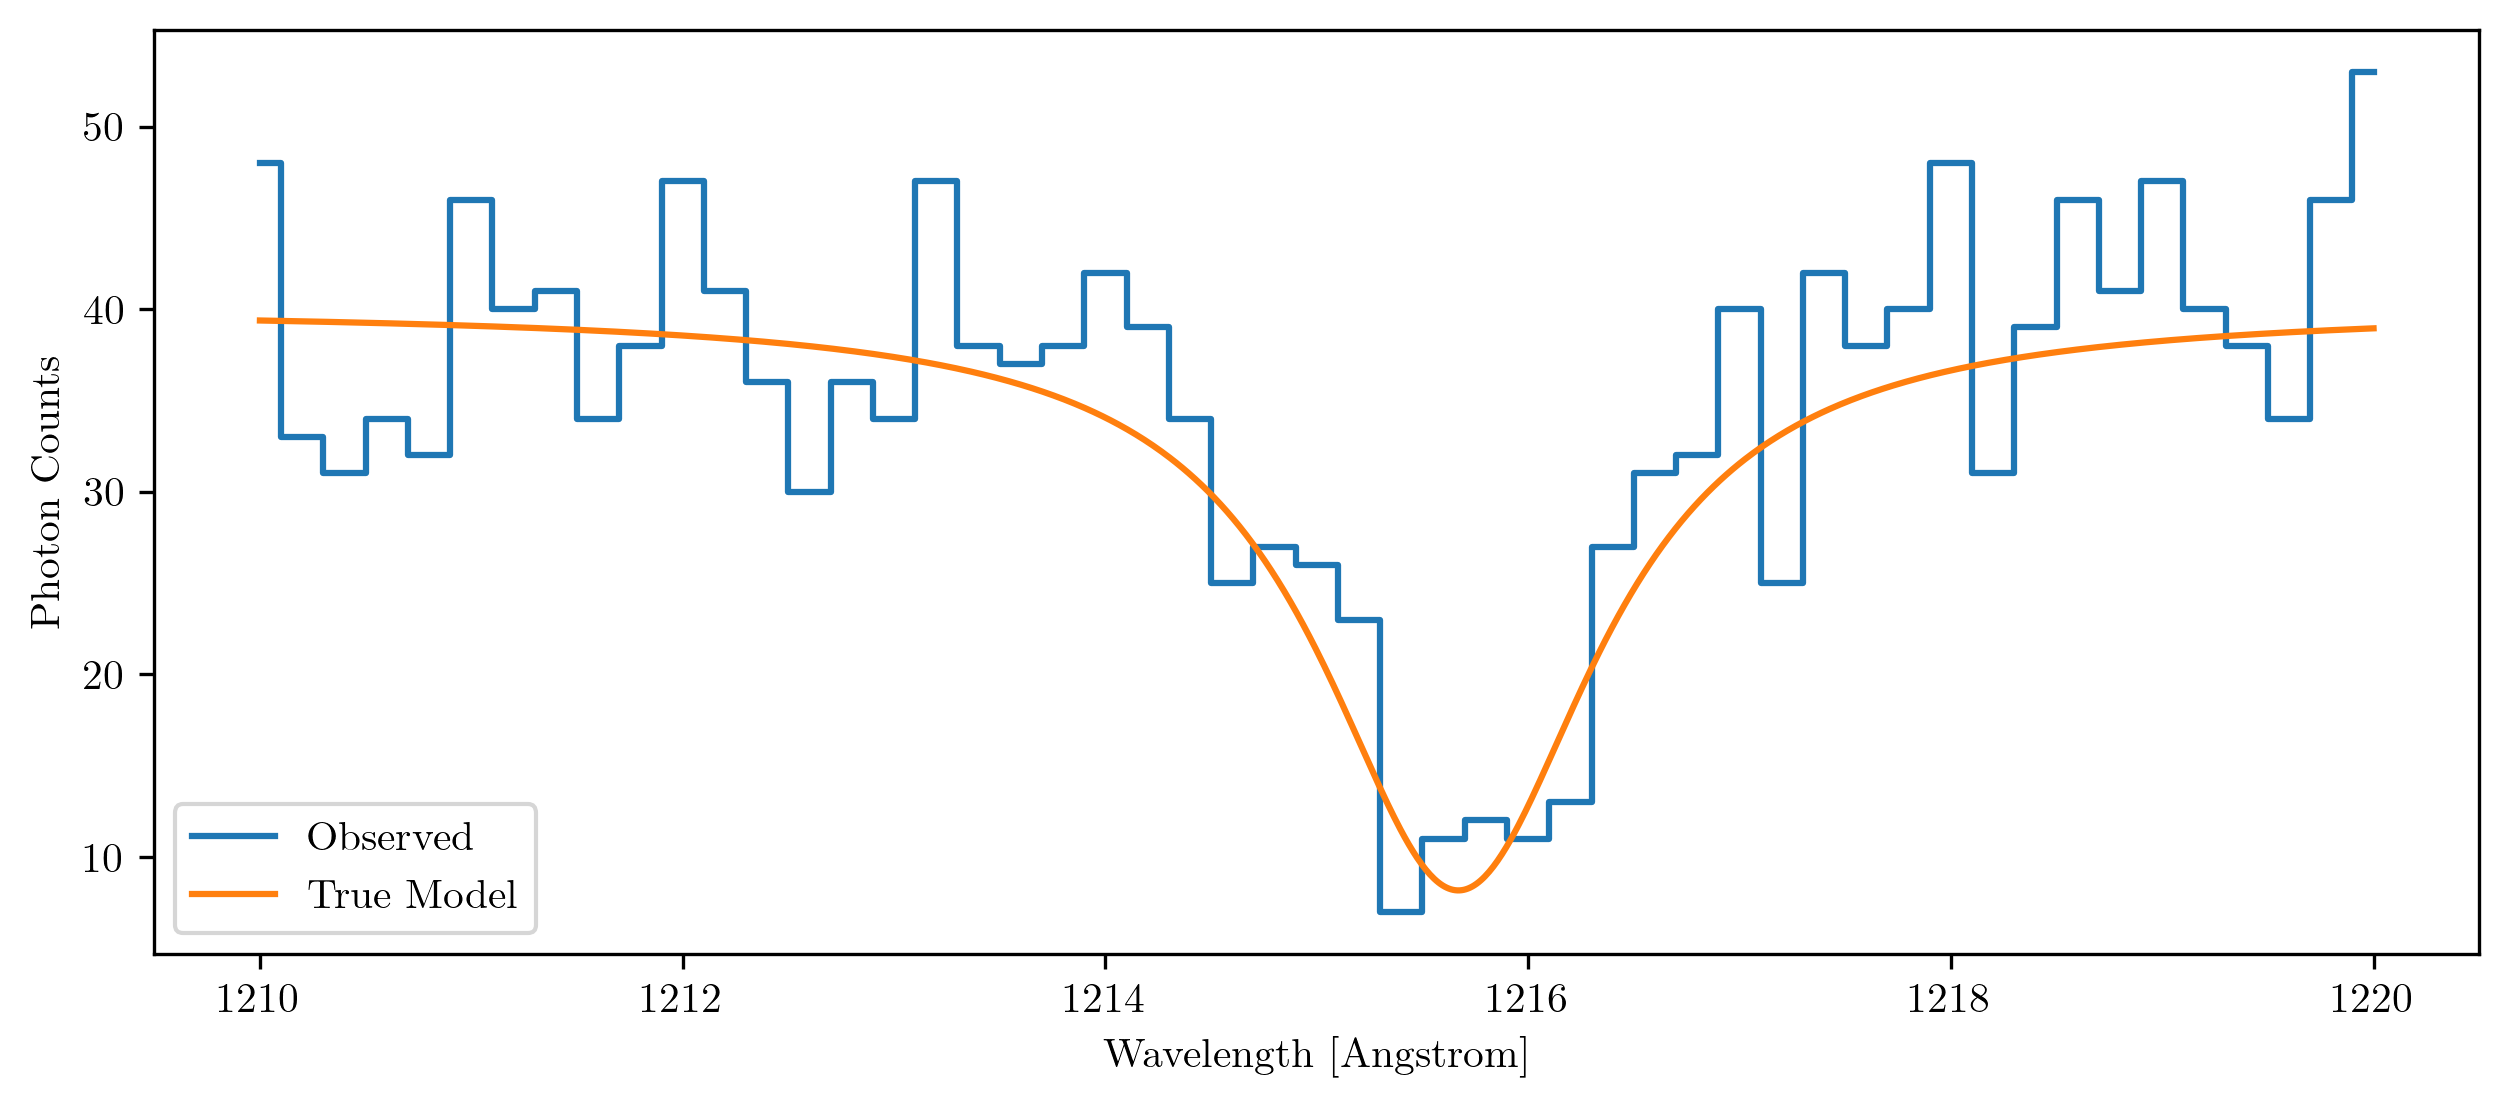

In [127]:
plt.figure(figsize=(10, 4))
plt.plot(lam, n_obs, drawstyle='steps-mid', label='Observed', color='C0')
plt.plot(x_model, y_model, label='True Model', color='C1')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Photon Counts')
plt.legend()
plt.show()

In [128]:
# Naive estimation of line properties
C_naive = np.mean(np.concatenate([n_obs[:5], n_obs[-5:]])) / dlam
deficit_naive = C_naive - n_obs / dlam

# NOTE: EDIT below to compute lam0_naive and W_naive
lam0_naive = np.sum(lam * deficit_naive * dlam) / np.sum(deficit_naive * dlam)
W_naive = np.sum(deficit_naive * dlam) / C_naive

lam0_naive_err = np.abs(lam0_naive - lam0_true) / lam0_true
W_naive_err = np.abs(W_naive - W_true) / W_true

print(f"Naive estimates:\n\tlam0 = {lam0_naive:.3f} Angstrom (relative error = {lam0_naive_err:.2%})\n\tW = {W_naive:.3f} Angstrom (relative error = {W_naive_err:.2%})")

Naive estimates:
	lam0 = 1214.822 Angstrom (relative error = 0.07%)
	W = 1.105 Angstrom (relative error = 44.76%)


#### Question 2.2: line properties from basis functions

The expected photon counts can be modeled by subtracting a sum of (normalized) Gaussian basis functions from the continuum level:

$\mu_g (\lambda) = C - \sum\limits_{i=1}^{M} a_i g_i (\lambda)$,

where the Gaussian basis functions share the same standard deviation $\sigma$ and are centered at arbitrary locations $\mu_i$ in the wavelength range $[\lambda_{\rm min}, \lambda_{\rm max}]$:

$g_i (\lambda) = \dfrac{1}{\sqrt{2\pi} \sigma} \exp\left[-\dfrac{(\lambda - \mu_i)^2}{2\sigma^2}\right], \quad i = 1, \ldots, n$


In this case, the area of each basis function is normalized to 1 (assume the tails outside the wavelength range $[\lambda_{\rm min}, \lambda_{\rm max}]$ are negligible):

$\displaystyle\int_{\lambda_{\rm min}}^{\lambda_{\rm max}} g_i (\lambda) \,{\rm d}\lambda \approx 1$

The equivalent width and line center can then be computed as derived parameters:

$W_g \approx \dfrac{1}{C} \sum\limits_{i=1}^{n} a_i \,[\AA]$

$\lambda_{0,g} \approx \dfrac{\sum\limits_{i=1}^{n} a_i \mu_i}{\sum\limits_{i=1}^{n} a_i}$


**Tasks:**
1. Using the same simulated spectrum from Question 2.1, fit the data with $M=1,2,3$ Gaussian basis functions. Infer the coefficients $\{a_i\}$ and continuum level $C$ using `UltraNest`, and report the inferred parameters $W_g$ and $\lambda_{0,g}$ along with their uncertainties. Use flat priors for all parameters: $C$ in $[100, 300]$ photons $\AA^{-1}$, $a_i$ in $[10, 200]$ photons, $\mu_i$ in $[\lambda_{\rm min}, \lambda_{\rm max}]\,\AA$, and $\sigma$ in $[0.1, 5.0]\,\AA$.
2. Compare the results from the basis function regression with the true parameters, as well as the naive estimates from Question 2.1.

In [ ]:
from scipy.special import xlogy, gammaln
from scipy.stats import norm

# Functions for UltraNest inference with Gaussian basis functions
def spec_gauss_model(lam, params):
    """Model spectrum with Gaussian basis functions.
    Args:
        lam: array, wavelength array in Ångström
        params: array, parameters [C, sigma, mu_1, ..., mu_M, a_1, ..., a_M]
    Returns:
        mu: array, model spectrum in photon counts per Angstrom
    """
    params = np.asarray(params)
    if params.size < 4:
        # not enough parameters -> return flat continuum placeholder
        C = params[0] if params.size >= 1 else 0.0
        return C + np.zeros_like(lam)

    C = params[0]
    sigma = params[1]
    # determine M from parameter length
    M = (params.size - 2) // 2
    mus = params[2:2+M] if M > 0 else np.array([])
    a = params[2+M:2+2*M] if M > 0 else np.array([])

    lam = np.asarray(lam)
    # normalized Gaussian basis functions (per Angstrom)
    if M == 0:
        n_model = C + np.zeros_like(lam)
    else:
        norm_factor = 1.0 / (np.sqrt(2.0 * np.pi) * sigma)
        # shape (M, len(lam))
        gauss = np.vstack([norm_factor * np.exp(-0.5 * ((lam - mu) / sigma) ** 2) for mu in mus])
        # subtract sum(a_i * g_i)
        n_model = C - np.sum((a[:, None] * gauss), axis=0)
    return n_model

def prior_transform_spec_gauss(cube, param_ranges):
    """Transform unit cube to parameter space.
    Args:
        cube: array, unit cube samples
        param_ranges: array, parameter ranges
    Returns:
        params: array, transformed parameters plus derived [W, lam0]
    """
    params = []
    cube = np.asarray(cube)
    for i, (pmin, pmax) in enumerate(param_ranges):
        params.append(pmin + cube[i] * (pmax - pmin))
    params = np.array(params)
    # compute derived parameters: equivalent width W_g and centroid lam0_g
    if params.size >= 4:
        M = (params.size - 2) // 2
        mus = params[2:2+M] if M > 0 else np.array([])
        a = params[2+M:2+2*M] if M > 0 else np.array([])
        C = params[0]
        sum_a = np.sum(a) if a.size > 0 else 0.0
        W = (sum_a / C) if C != 0 else 0.0
        lam0 = (np.sum(a * mus) / sum_a) if sum_a > 0 else (np.mean(mus) if mus.size > 0 else 0.0)
    else:
        W = 0.0
        lam0 = 0.0
    return np.concatenate([params, np.array([W, lam0])])

def log_likelihood_spec_gauss(params, lam, n_obs, dlam):
    """Compute log-likelihood for Gaussian basis function model.
    Args:
        params: array, model parameters [C, sigma, mu_1, ..., mu_M, a_1, ..., a_M]
        lam: array, wavelength array
        n_obs: array, observed photon counts (per bin)
        dlam: float, wavelength bin size
    Returns:
        logL: float, log-likelihood value
    """
    params = np.asarray(params)
    if params.size < 4:
        return -1e99

    n_total = params.size
    if n_total >= 4 and (n_total - 2) % 2 == 0:
        model_len = n_total
    elif n_total >= 6 and (n_total - 4 - 2) % 2 == 0:
        model_len = n_total - 2
    else:
        model_len = n_total
    M = (model_len - 2) // 2
    n_model_params = 2 + 2 * M
    model_params = params[:n_model_params]

    C = float(model_params[0])
    sigma = float(model_params[1])

    try:
        mu_per_A = spec_gauss_model(lam, model_params)
    except Exception:
        return -1e99

    lam_counts = mu_per_A * dlam

    eps = 1e-8
    if not np.all(np.isfinite(lam_counts)) or np.any(n_obs < 0) or C <= 0 or sigma <= 0:
        return -1e99
    lam_counts = np.maximum(lam_counts, eps)

    logL = np.sum(xlogy(n_obs, lam_counts) - lam_counts - gammaln(n_obs + 1.0))
    return float(logL)

In [156]:
spec_gauss_num = [1, 2, 3]  # Number of Gaussian basis functions
ultranest_results_spec_gauss = []
spec_derived_param_names = ['W', 'lam0']

for M in spec_gauss_num:
    pnames = ['C', 'sigma'] + [f'mu{j+1}' for j in range(M)] + [f'a{j+1}' for j in range(M)]
    pranges = [[100, 300], [0.1, 3.0]] + [[1210, 1220]] * M + [[0, 400]] * M

    # NOTE: EDIT below to setup and run the UltraNest sampler
    sampler = ultranest.ReactiveNestedSampler(
        pnames,
        lambda params: log_likelihood_spec_gauss(params, lam, n_obs, dlam),
        lambda cube: prior_transform_spec_gauss(cube, pranges),
        derived_param_names=spec_derived_param_names,
        log_dir=f'spec_gauss_M{M}',
    )

    np.random.seed(seed)

    sampler.stepsampler = stepsampler.SliceSampler(
        nsteps=2 * len(pnames),
        generate_direction=stepsampler.generate_mixture_random_direction
    )

    results = sampler.run()
    ultranest_results_spec_gauss.append(results)

Creating directory for new run spec_gauss_M1/run4


Creating directory for new run spec_gauss_M2/run485..-227.5058]*| it/evals=3400/62079 eff=5.5124% N=400 


Creating directory for new run spec_gauss_M3/run402..-157.8901]*| it/evals=6640/192812 eff=3.4509% N=400 


Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 2400x2400 with 0 Axes>

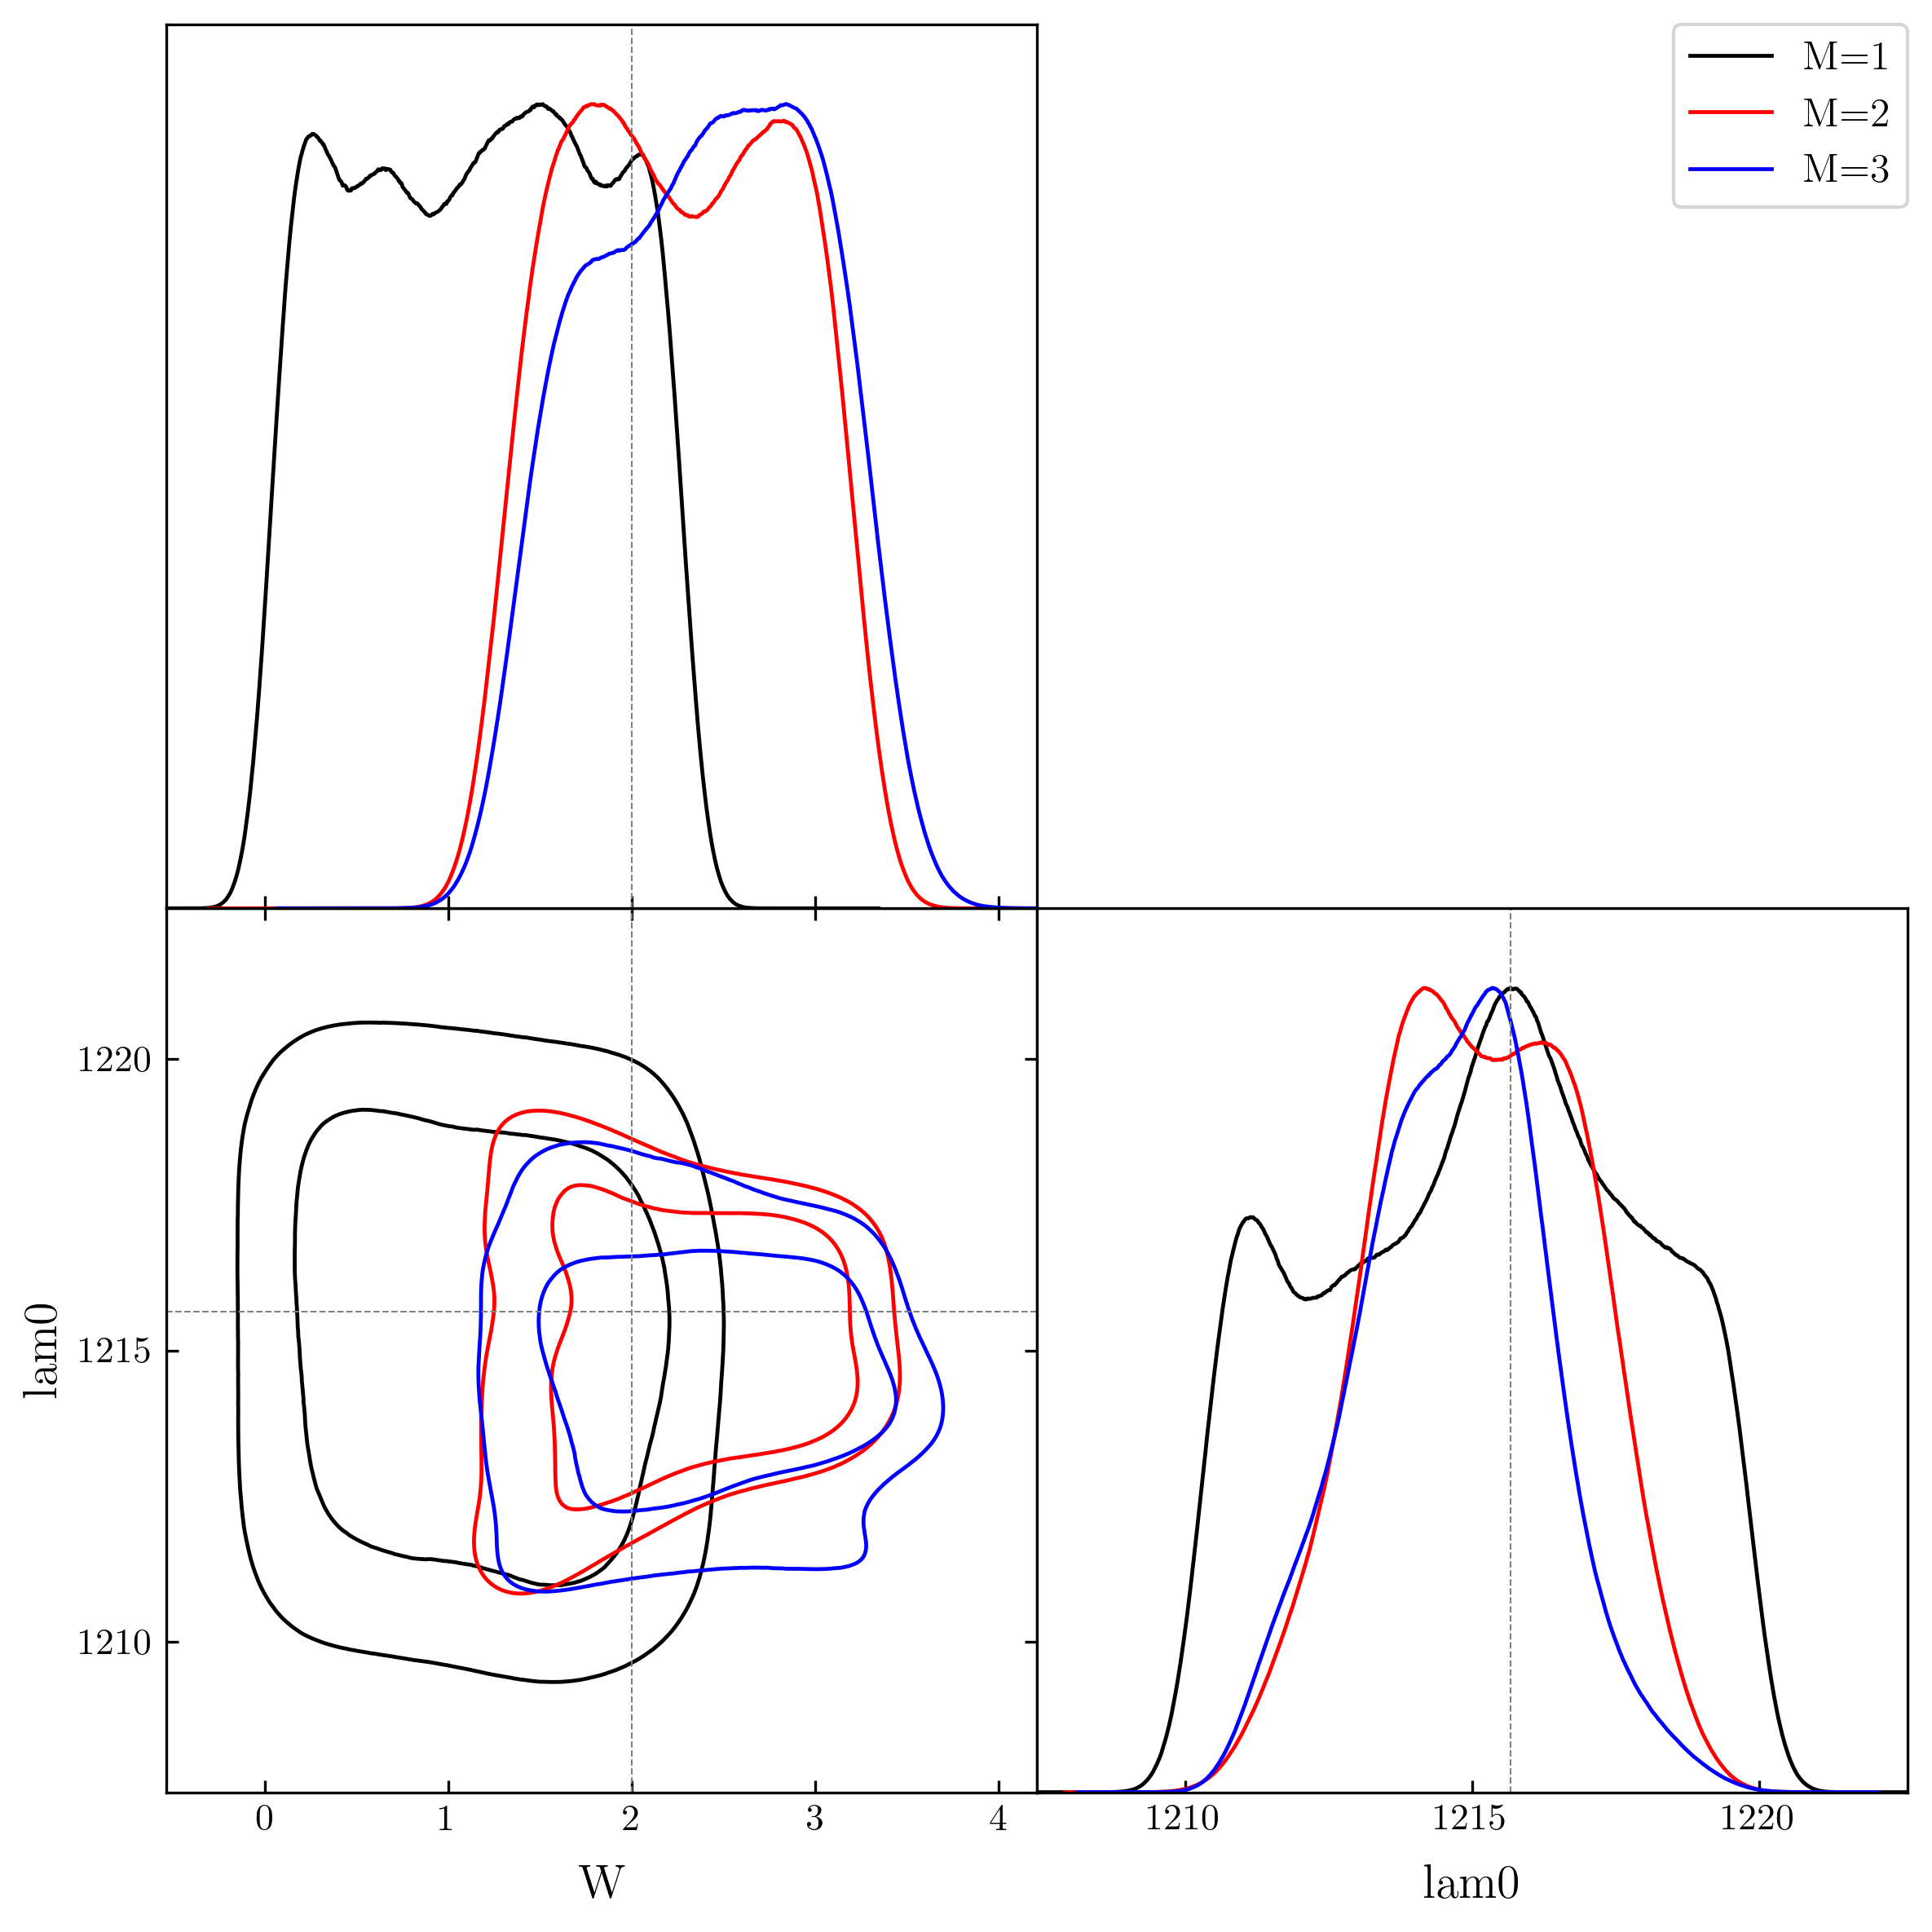

In [157]:
# Convert UltraNest results to getdist MCSamples and make corner plots
getdist_spec_gauss_samples = []

for i, M in enumerate(spec_gauss_num):
    results = ultranest_results_spec_gauss[i]

    # NOTE: EDIT below to convert UltraNest results to GetDist MCSamples
    ws = results['weighted_samples']
    start_idx = 2 + 2 * M  # skip C, sigma, mu_1..mu_M, a_1..a_M
    samples = MCSamples(
        samples=ws['points'][:, start_idx:],
        weights=ws['weights'],
        loglikes=-ws['logl'],
        names=spec_derived_param_names,
        sampler='nested'
    )
    getdist_spec_gauss_samples.append(samples)

# Make corner plots
g = plots.get_single_plotter(width_inch=8, ratio=1.0)
g.triangle_plot(
    getdist_spec_gauss_samples,
    param_names=spec_derived_param_names,
    filled=False,
    markers={'W': W_true, 'lam0': lam0_true},
    legend_labels=[f'M={M}' for M in spec_gauss_num],
    legend_loc='upper right'
)

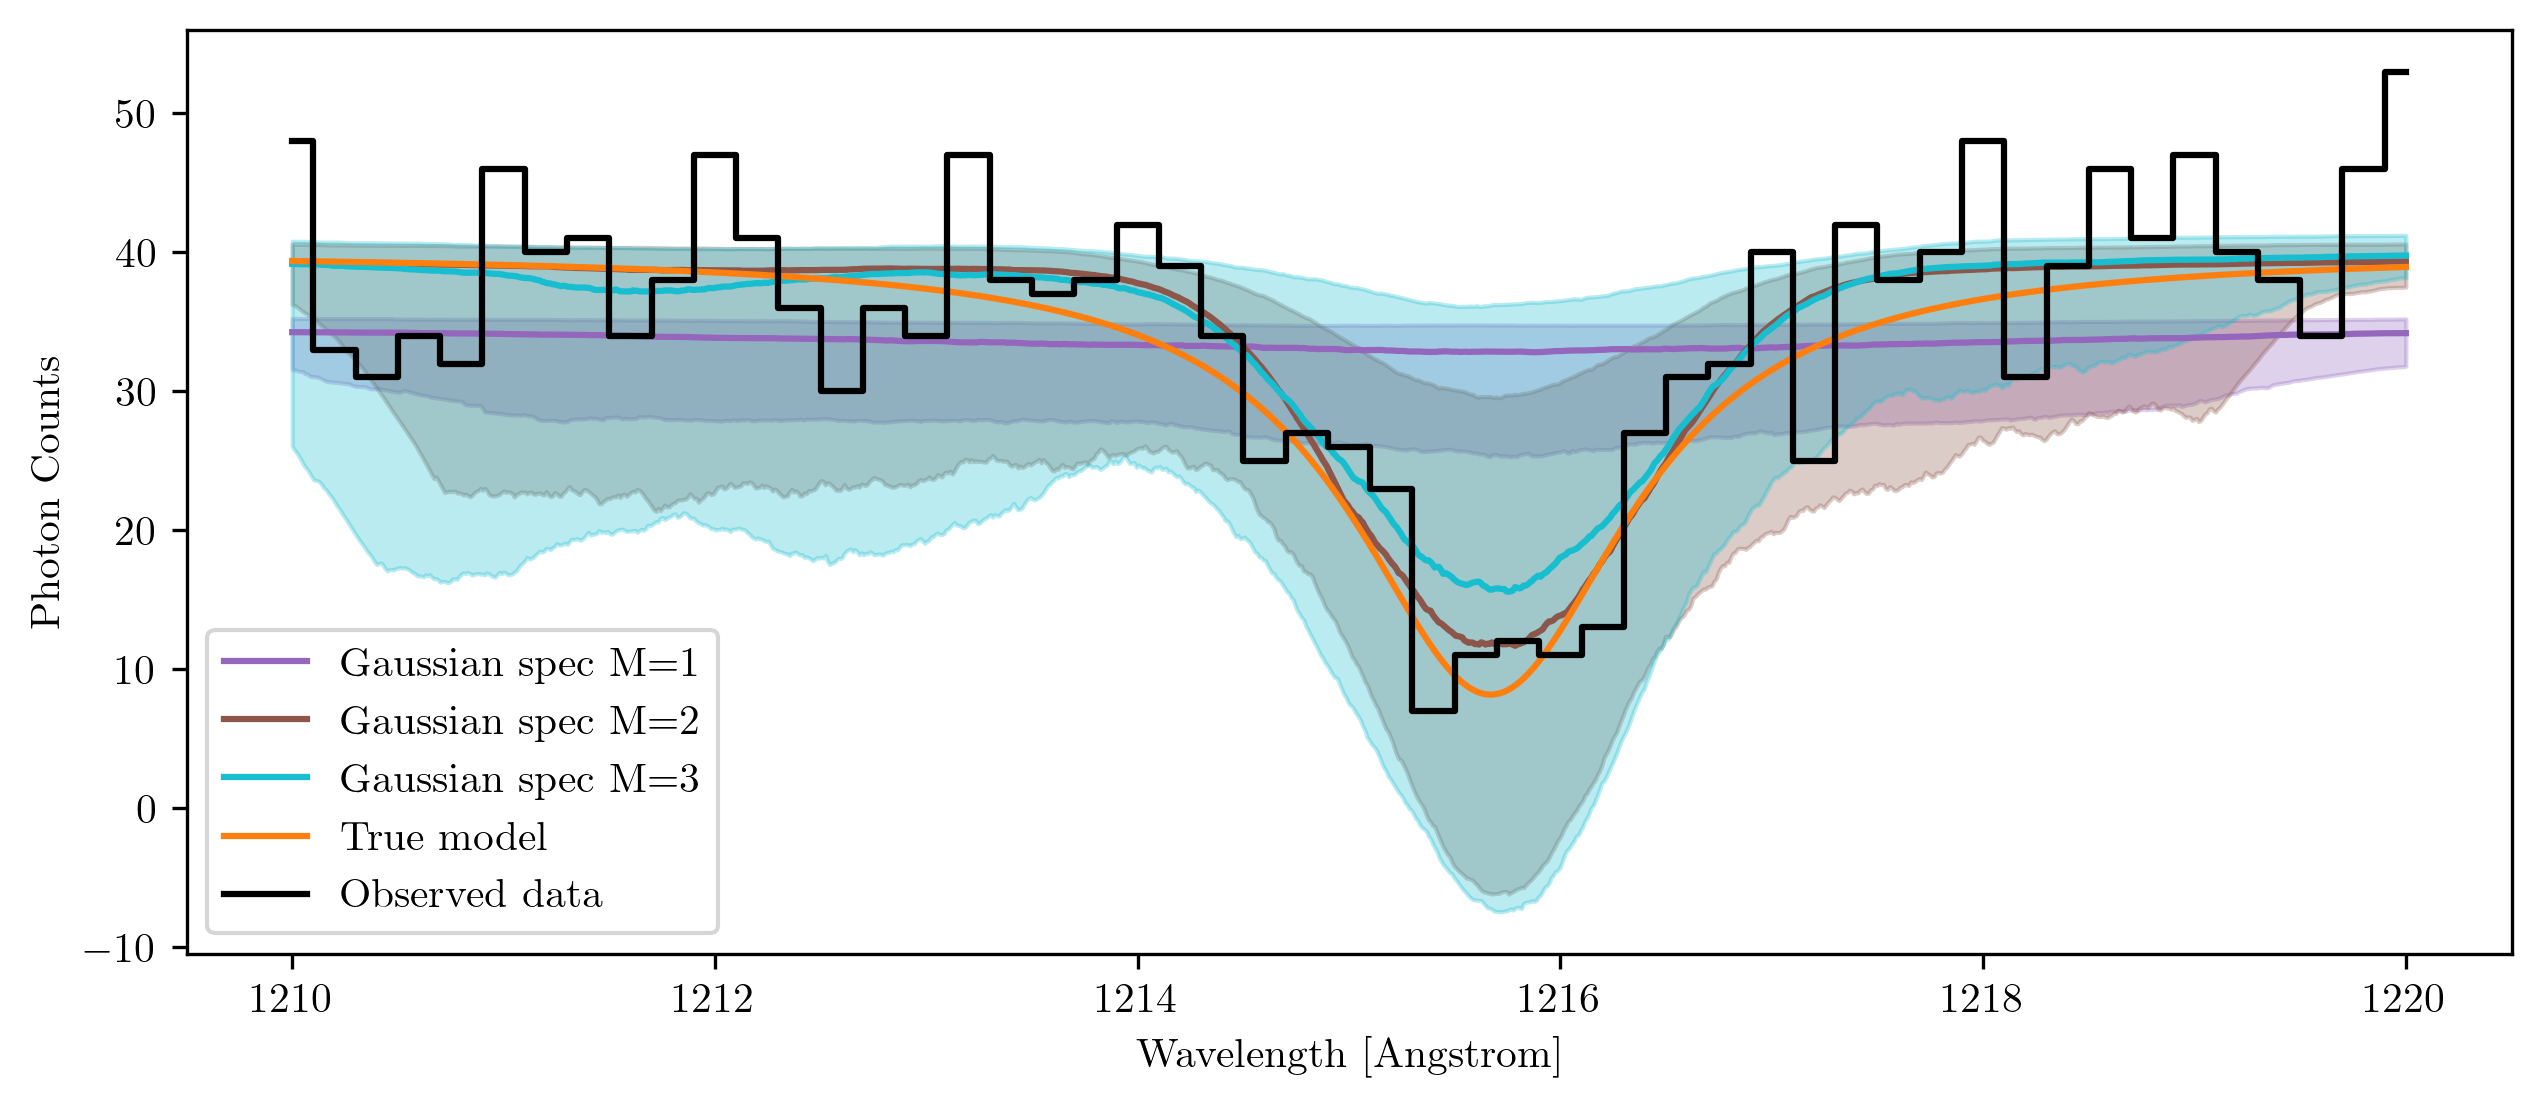

In [158]:
# Plot the predictive bands from Gaussian basis function models
plt.figure(figsize=(10, 4))
colors = ['tab:purple', 'tab:brown', 'tab:cyan']

rng = np.random.default_rng(seed)

for i, M in enumerate(spec_gauss_num):
    results = ultranest_results_spec_gauss[i]
    t_sample = x_model
    pband = PredictionBand(t_sample)
    n_model_params = 2 + 2 * M

    ws = results['weighted_samples']
    pts = np.asarray(ws['points'])[:, :n_model_params]
    weights = np.asarray(ws['weights'], dtype=float)
    if weights.sum() <= 0 or len(weights) == 0:
        for p in results.get('samples', []):
            pband.add(spec_gauss_model(t_sample, p[:n_model_params]) * dlam)
    else:
        probs = weights / weights.sum()
        n_draw = 2000
        idx = rng.choice(len(pts), size=n_draw, p=probs)
        for ind in idx:
            p = pts[ind]
            pband.add(spec_gauss_model(t_sample, p) * dlam)

    pband.line(color=colors[i], label=f'Gaussian spec M={M}')
    pband.shade(color=colors[i], alpha=0.3)

plt.plot(x_model, y_model, label='True model', color='tab:orange')
plt.step(lam, n_obs, where='mid', label='Observed data', color='k')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Photon Counts')
plt.legend()
plt.show()

#### Question 2.3: line properties from parametric model

**Tasks:**
1. Assume the Lorentzian absorption line model is known, fit the simulated spectrum using `UltraNest`. Use uniform priors over the following ranges:
   - $A \in [100, 800]$ photons
   - $\lambda_0 \in [1210, 1220]\,\AA$
   - $\gamma \in [0.1, 2.0]\,\AA$
   - $C \in [100, 300]\,{\rm photon}\,\AA^{-1}$
2. Infer the equivalent width $W$ as a derived parameter.
3. Report summary statistics of the inferred parameters, and compare with the results from Questions 2.1 and 2.2.
4. Discuss all your findings for the whole exercise.

In [159]:
from scipy.special import xlogy, gammaln

# Functions for UltraNest inference with the true parametric model
def prior_transform_spec(cube, param_ranges):
    """Transform unit cube to parameter space.
    Args:
        cube: array, unit cube samples (A, lam0, gamma, C)
        param_ranges: array, parameter ranges
    Returns:
        params: array, transformed parameters + derived parameter
    """
    params = []
    for i, (pmin, pmax) in enumerate(param_ranges):
        params.append(pmin + (pmax - pmin) * cube[i])
    # Add derived parameter: EW
    params.append(params[0] / params[3])
    return np.array(params)

def log_likelihood_spec(params, lam, n_obs, dlam):
    """Compute log-likelihood for the true parametric spectral model.
    Args:
        params: array, model parameters (A, lam0, gamma, C)
        lam: array, wavelength array
        n_obs: array, observed photon counts
        dlam: float, wavelength bin size
    Returns:
        logL: float, log-likelihood value
    """
    # NOTE: EDIT below to complete this function
    params = np.asarray(params)
    if params.size < 4:
        return -1e99
    A, lam0, gamma, C = params[:4]

    # compute model (photons per Angstrom) and expected counts per bin
    try:
        mu_per_A = spec_model(lam, A, lam0, gamma, C)
    except Exception:
        return -1e99

    lam_counts = mu_per_A * dlam

    # numeric checks and floor
    eps = 1e-8
    if not np.all(np.isfinite(lam_counts)) or np.any(n_obs < 0) or C <= 0:
        return -1e99
    lam_counts = np.maximum(lam_counts, eps)

    # Poisson log-likelihood
    logL = np.sum(xlogy(n_obs, lam_counts) - lam_counts - gammaln(n_obs + 1.0))
    return logL

In [160]:
param_spec_names = ['A', 'lam0', 'gamma', 'C']
param_spec_true = [400, 1215.67, 0.8, 200]
param_spec_ranges = [(100, 800), (1210, 1220), (0.1, 2), (100, 300)]

log_dir = 'spec_true_model'

# NOTE: EDIT below to setup the UltraNest sampler
sampler = ultranest.ReactiveNestedSampler(
    param_spec_names,
    lambda params: log_likelihood_spec(params, lam, n_obs, dlam),
    lambda cube: prior_transform_spec(cube, param_spec_ranges),
    derived_param_names=['W'],
    log_dir=log_dir,
)

sampler.stepsampler = stepsampler.SliceSampler(
    nsteps=2 * len(param_spec_names),
    generate_direction=stepsampler.generate_mixture_random_direction
)

results_spec_true = sampler.run()

Creating directory for new run spec_true_model/run2


Removed no burn in


<Figure size 1800x1800 with 0 Axes>

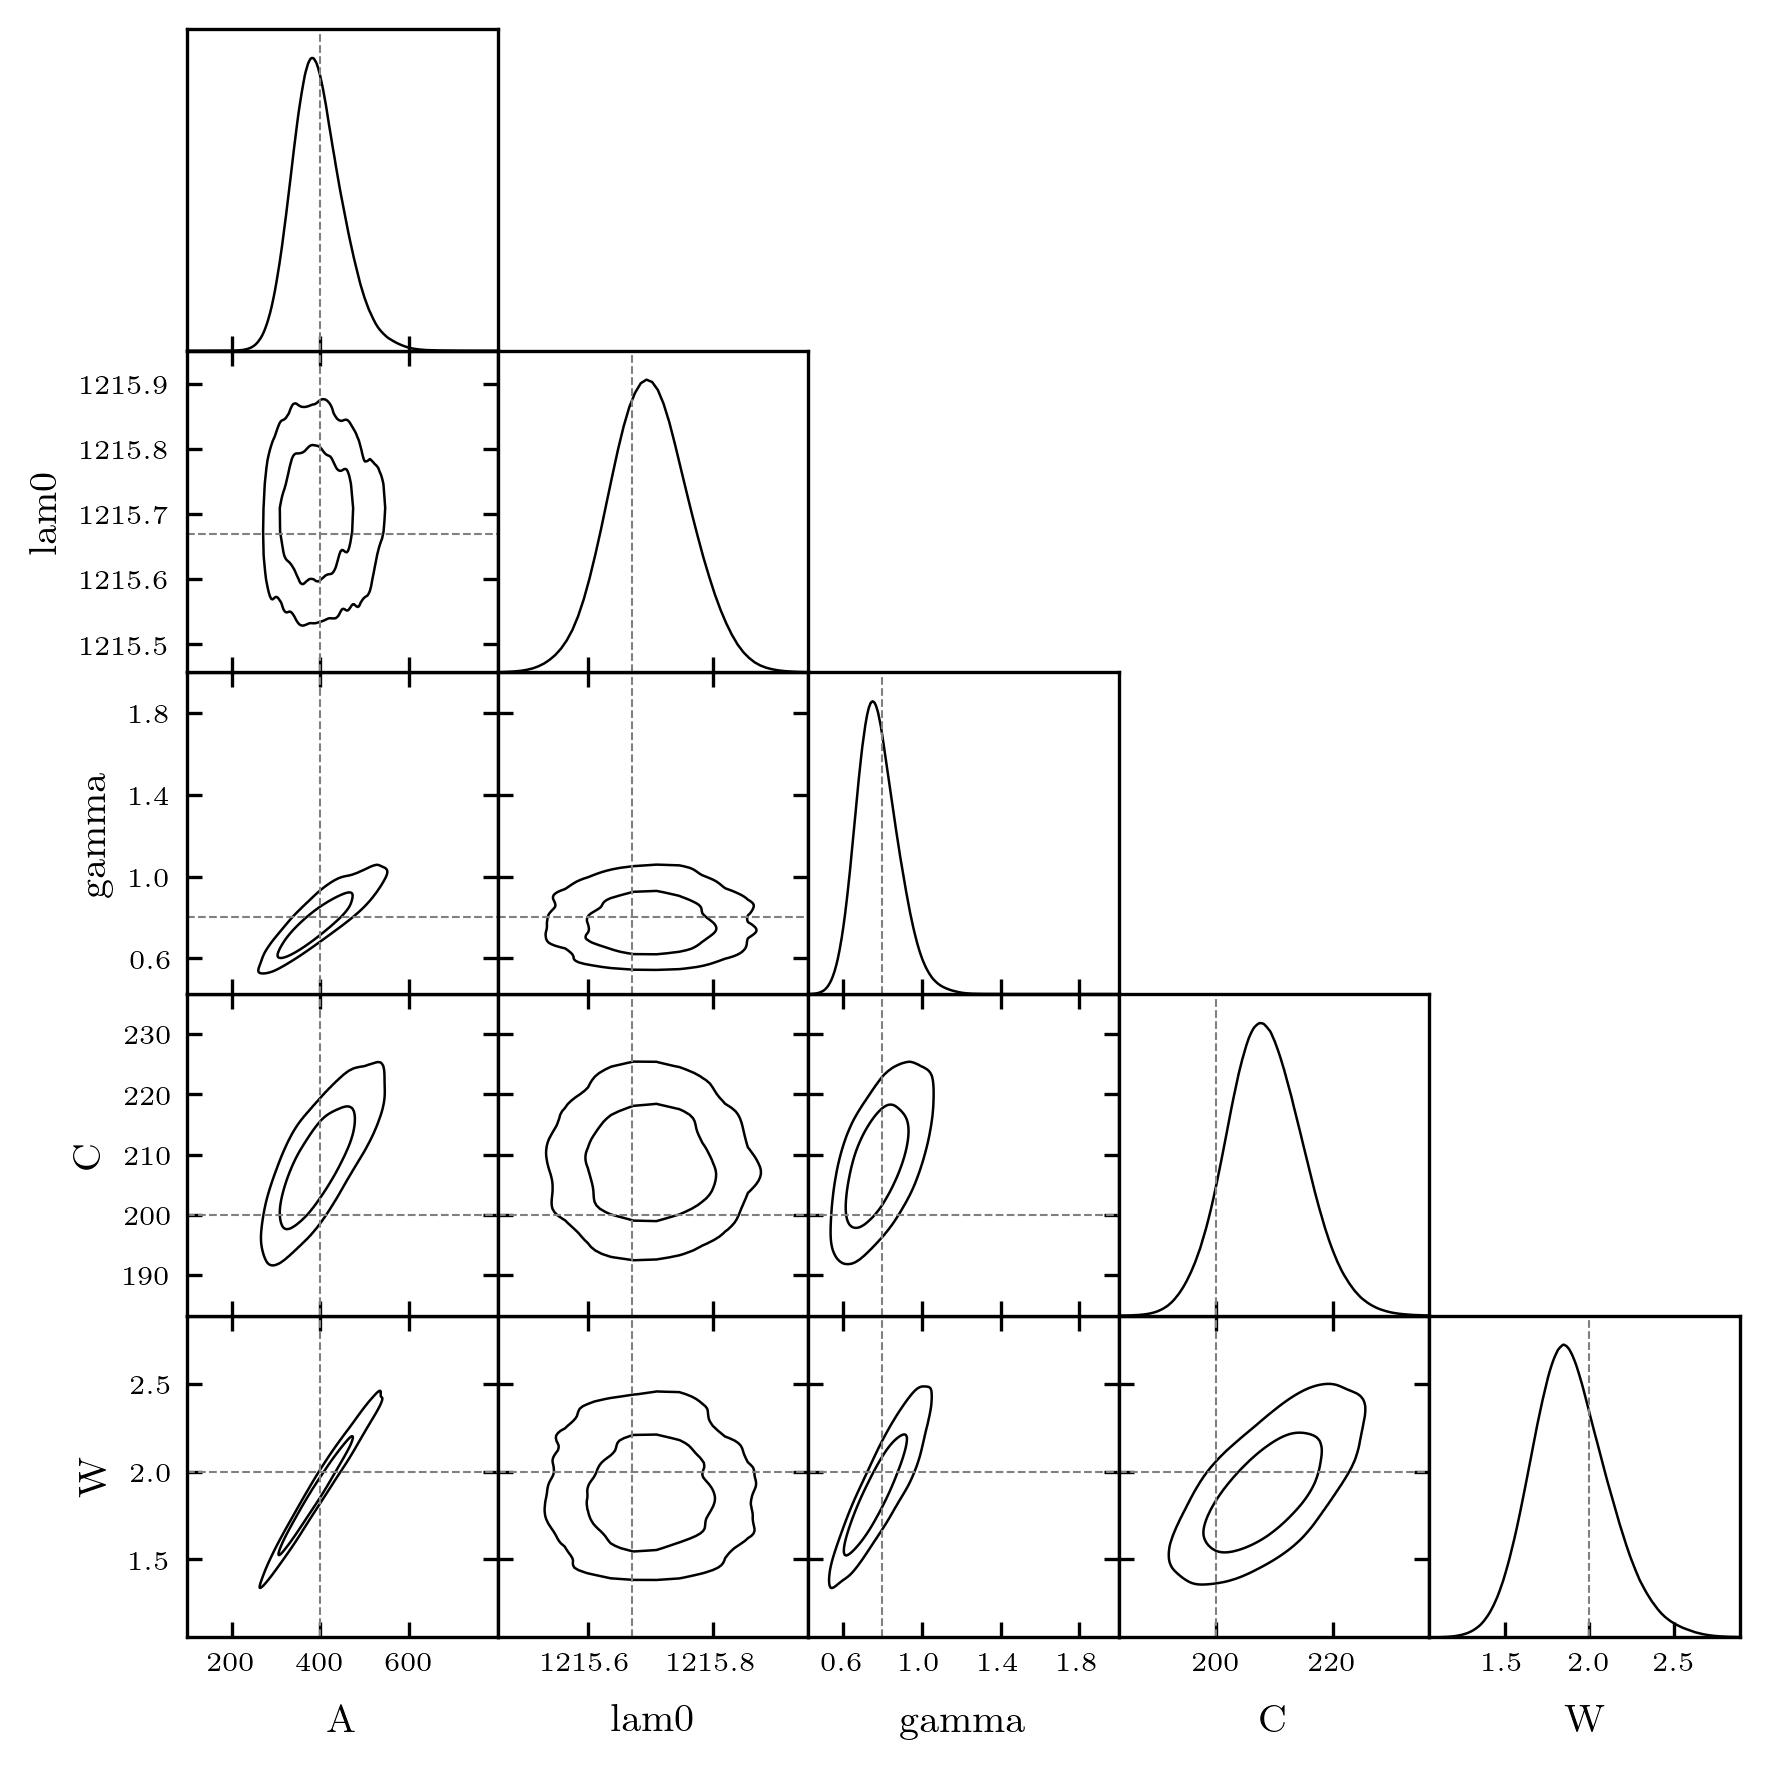

In [161]:
# Make corner plot using getdist
ws = results_spec_true['weighted_samples']

samples = MCSamples(
    samples=ws['points'],
    weights=ws['weights'],
    loglikes=-ws['logl'],
    names=param_spec_names + ['W'],
    ranges={n:p for n,p in zip(param_spec_names + ['W'], param_spec_ranges + [[None, None]])},
    sampler='nested'
)

g = plots.get_single_plotter(width_inch=6, ratio=1.0)
g.triangle_plot(
    samples,
    markers={n:v for n,v in zip(param_spec_names + ['W'], param_spec_true + [W_true])}
)

##### Discussions

从结果来看，模拟能够给出包含真值的一个范围，但是误差还是较大.

### Note: steps for submitting the exercise

1. In the menu bar, select `File > Download` to download your notebook as a `.ipynb` file.
2. Select `File > Save and Export Notebook As > PDF` to export your notebook as a PDF file.
3. Combine the `.ipynb` and `.pdf` files into a single `.zip` or `.tar.gz` archive.
4. Upload your archive to the web learning platform (网络学堂).